In [ ]:
# @title installations
!pip install -q textblob
!python -m textblob.download_corpora
!pip install ace_tools

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
Finished.


In [ ]:
# @title import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from textblob import TextBlob
import nltk
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
import regex

In [ ]:
# @title downloads
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# @title Load and clean dataset
df = pd.read_excel('/content/Baseline Assessment Tool.xlsx')
df.columns = df.columns.str.strip()  # Clean column headers

# df.columns.tolist()
df['Industry/Sector of the business'] = df['Industry/Sector of the business'].astype(str).str.strip().str.title()
# Standardize Location column to remove duplicates caused by inconsistencies
df['Location:'] = df['Location:'].astype(str).str.strip().str.title()

In [ ]:
# --- UPDATE LOCATIONS ---
location_map = {
    'Mogwase': 'Mogalakwena'  # Merge Mogwase under Mogalakwena
}
df['Location:'] = df['Location:'].replace(location_map)

# --- UPDATE INDUSTRY GROUPINGS ---
industry_merge = {
    # Hospitality and Support Services
    'Catering, Food And Beverages': 'Hospitality and Support Services',
    'Mining Support Services': 'Hospitality and Support Services',

    # Infrastructure and Engineering
    'Mine Engineering And Technical': 'Infrastructure and Engineering',
    'Civil Engineering': 'Infrastructure and Engineering',
    'Construction': 'Infrastructure and Engineering',

    # Utilities and Technical Services
    'Electrical, Gas, Air Conditioning': 'Utilities and Technical Services',
    'Machine Repair And Installations': 'Utilities and Technical Services',

    # ICT and Digital Services
    'Ict': 'ICT and Digital Services',

    # Manufacturing and Industrial
    'Manufacturing': 'Manufacturing and Industrial',
    'Mine Equipment Supplies': 'Manufacturing and Industrial',

    # Ground preparation and excavation
    'Mining And Quarrying': 'Ground preparation and excavation',

    # Security Services
    'Security And Investigations': 'Security Services',

    # Transport and Tourism
    'Transport And Tour Operator': 'Transport and Tourism',

    # Keep 'Other' as is
    'Other': 'Other'
}

df['Industry/Sector of the business'] = df['Industry/Sector of the business'].replace(industry_merge)

# Display the cleaned unique values for validation
unique_locations = df['Location:'].unique()
unique_industries = df['Industry/Sector of the business'].unique()

(unique_locations, unique_industries)

(array(['Mogalakwena', 'Polokwane', 'Rustenburg', 'Amandelbult'],
       dtype=object),
 array(['Ground Preparation And Excavation',
        'Infrastructure And Engineering', 'Security Services',
        'Utilities And Technical Services',
        'Hospitality And Support Services', 'Ict And Digital Services',
        'Manufacturing And Industrial', 'Transport And Tourism',
        'Energy And Fuel Services'], dtype=object))

In [ ]:
print(df.columns.tolist())

['Completion time', 'Business Name', 'VAT Number:', 'Location:', 'Industry/Sector of the business', 'Contact Details:', 'Year in Operation:', 'Financial year end (month):', 'Types of Ownership:', 'B-BBE Level:', 'Name of Business Owner(s):', 'Kindly state age range', 'Gender', 'Directors of the Business:', 'Who is/are the managing directors (daily running of business)?', 'How many permanent (Full time) FEMALE employees does the business have? These should work minimum of 21 hours a week and earn National minimum wage and above.', 'How many permanent (Full time) MALE employees does the business have? These should work minimum of 21 hours a week and earn National minimum wage and above.', 'How many temporary (part time) FEMALE employees does the business have? These should work 9-20 hours a week and earn National minimum wage and above', 'How many temporary (part time) MALE employees does the business have? These should work 9-20 hours a week and earn National minimum wage and above', 'H

🔹 Sentiment on Sustainability by Site:


,Sustainability Sentiment
Location,
Amandelbult,-0.03
Mogalakwena,-0.10
Polokwane,-0.12
Rustenburg,0.11


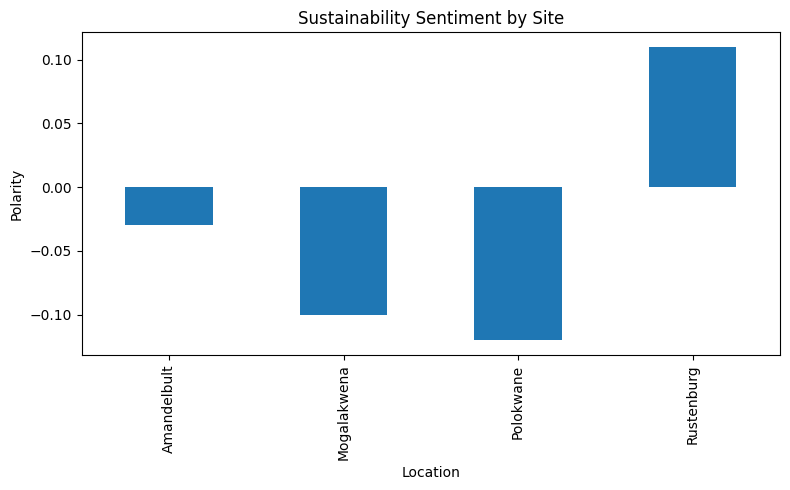

🔹 Sentiment on Competitiveness by Site:


,Competitiveness Sentiment
Location,
Amandelbult,0.12
Mogalakwena,0.10
Polokwane,0.04
Rustenburg,0.24


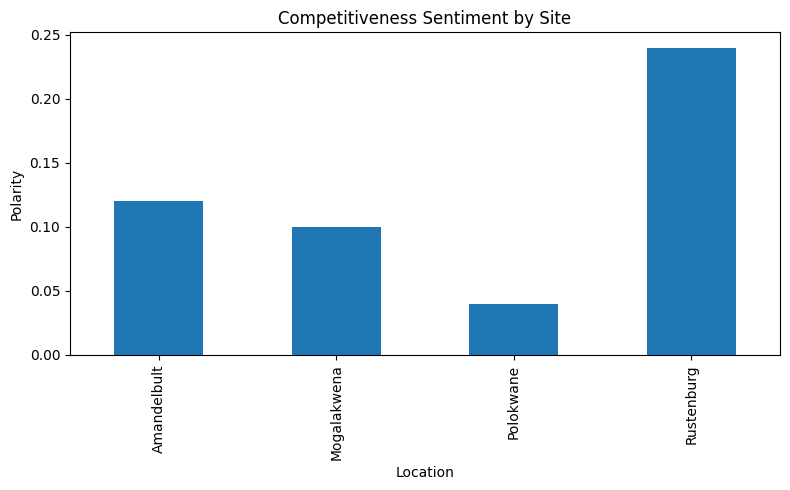

🔹 Top Keywords - Sustainability Issues:
['base' 'business' 'customer' 'customers' 'engagement' 'financial' 'lack'
 'management' 'skills' 'weak']
🔹 Top Keywords - Competitiveness:
['business' 'customer' 'market' 'marketing' 'new' 'offer' 'products'
 'quality' 'service' 'services']


In [ ]:
# @title SECTION 1: Profiling and Demographics

def create_ownership_tables(df):

    cols = [
        'Industry/Sector of the business',
        'State the Black Ownership of the business',
        'State the Black Woman Ownership of the business',
        'Gender',
        'Kindly state age range',
        'Year in Operation:',
        'Location:'
    ]

    ownership_df = df[cols].copy()
    ownership_df.columns = [
        'Industry', 'BlackOwnership', 'BlackWomanOwnership',
        'Gender', 'Age', 'YearsInOp', 'Location'
    ]

    # Drop rows missing key demographic fields
    ownership_df.dropna(subset=['Industry', 'BlackOwnership', 'Gender', 'Age'], inplace=True)

    # Clean text fields
    ownership_df['Industry'] = ownership_df['Industry'].str.title().str.strip()
    ownership_df['Location'] = ownership_df['Location'].str.title().str.strip()
    ownership_df['BlackOwnershipPct'] = pd.to_numeric(ownership_df['BlackOwnership'], errors='coerce') * 100
    ownership_df['IsBlackOwned'] = ownership_df['BlackOwnershipPct'] >= 51
    ownership_df['IsBlackWomanOwned'] = ownership_df['BlackWomanOwnership'].str.strip().str.lower() == 'more than 30%'
    ownership_df['YearsInOp'] = pd.to_numeric(ownership_df['YearsInOp'], errors='coerce').round(0).astype('Int64')

    # Youth identification
    ownership_df['AgeCleaned'] = ownership_df['Age'].astype(str).str.strip().str.lower()
    ownership_df['IsYouth'] = ownership_df['AgeCleaned'] == 'less than 35'

    black_owners = ownership_df[ownership_df['IsBlackOwned']]

    def summarize_by(group_field):
        grouped = ownership_df.groupby(group_field)
        table = grouped.agg(
            Num_Contractors=(group_field, 'size'),
            Avg_Yrs_In_Operation=('YearsInOp', 'mean')
        ).round(0)

        # Demographics
        youth = ownership_df[ownership_df['IsYouth']].groupby(group_field).size()
        black_total = black_owners.groupby(group_field).size()
        male = black_owners[black_owners['Gender'].str.lower().str.strip() == 'male'].groupby(group_field).size()
        female = black_owners[black_owners['Gender'].str.lower().str.strip() == 'female'].groupby(group_field).size()
        other = black_owners[~black_owners['Gender'].str.lower().str.strip().isin(['male', 'female'])].groupby(group_field).size()

        # Fill missing values with 0 for computation
        table['Black Ownership %'] = ((black_total / table['Num_Contractors']) * 100).round(0).astype('Int64').astype(str) + '%'

        table['Youth owned (<35 yrs)'] = youth
        table['Youth owned %'] = ((youth / table['Num_Contractors']) * 100).round(0).astype('Int64').astype(str) + '%'

        table['Black Male ownership'] = male
        table['Black Male %'] = ((male / table['Num_Contractors']) * 100).round(0).astype('Int64').astype(str) + '%'

        table['Black Female Ownership'] = female
        table['Black Female %'] = ((female / table['Num_Contractors']) * 100).round(0).astype('Int64').astype(str) + '%'

        table['Black other'] = other
        table['Black Other %'] = ((other / table['Num_Contractors']) * 100).round(0).astype('Int64').astype(str) + '%'

        # Clean up: fill counts with '' where 0 and ensure display friendly
        for col in ['Youth owned (<35 yrs)', 'Black Male ownership', 'Black Female Ownership', 'Black other']:
            table[col] = table[col].fillna('').replace({0: ''})

        table.fillna('', inplace=True)

        table.reset_index(inplace=True)
        table.rename(columns={
            group_field: 'Industry/Sector' if group_field == 'Industry' else 'Location/Site',
            'Num_Contractors': '# of Contractors',
            'Avg_Yrs_In_Operation': 'Ave Yrs in operation'
        }, inplace=True)

        return table

    table1 = summarize_by('Industry')
    table2 = summarize_by('Location')

    return table1, table2

table1_industry, table2_location = create_ownership_tables(df)


# --- 1E: QUALITATIVE THEMATIC & SENTIMENT ANALYSIS ---
qual_cols = ['Location:', 'What issues affect sustainability in the business?', 'What is the SME doing to ensure it remains competitive/relevant?']

if all(col in df.columns for col in qual_cols):
    qual_df = df[qual_cols].dropna()
    qual_df.columns = ['Location', 'Sustainability', 'Competitiveness']

    qual_df['Sustainability Sentiment'] = qual_df['Sustainability'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    qual_df['Competitiveness Sentiment'] = qual_df['Competitiveness'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

    sust_sent = qual_df.groupby('Location')['Sustainability Sentiment'].mean().round(2)
    comp_sent = qual_df.groupby('Location')['Competitiveness Sentiment'].mean().round(2)

    print("🔹 Sentiment on Sustainability by Site:")
    display(sust_sent)
    sust_sent.plot(kind='bar', title='Sustainability Sentiment by Site', ylabel='Polarity', figsize=(8, 5))
    plt.tight_layout()
    plt.show()

    print("🔹 Sentiment on Competitiveness by Site:")
    display(comp_sent)
    comp_sent.plot(kind='bar', title='Competitiveness Sentiment by Site', ylabel='Polarity', figsize=(8, 5))
    plt.tight_layout()
    plt.show()

    # Top Keywords
    print("🔹 Top Keywords - Sustainability Issues:")
    vec_sust = CountVectorizer(stop_words='english', max_features=10)
    vec_sust.fit_transform(qual_df['Sustainability'])
    print(vec_sust.get_feature_names_out())

    print("🔹 Top Keywords - Competitiveness:")
    vec_comp = CountVectorizer(stop_words='english', max_features=10)
    vec_comp.fit_transform(qual_df['Competitiveness'])
    print(vec_comp.get_feature_names_out())


🔹 Gender Distribution:


,count
Gender,
Male,33
Female,30
Prefer Not To Say,1


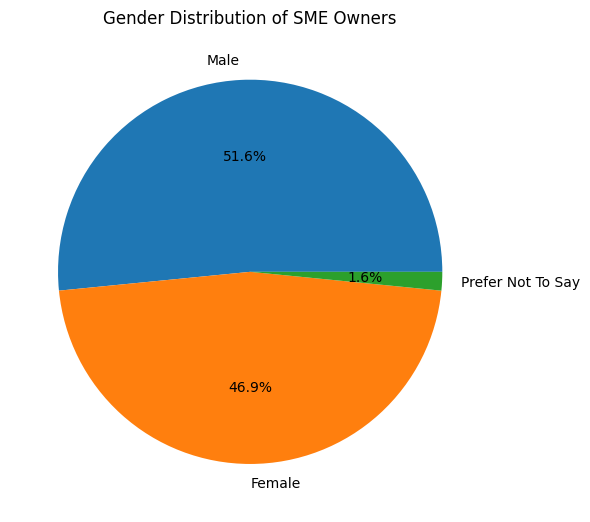

In [ ]:
# --- GENDER AND AGE GROUP PROFILING ---

# Clean column names
gender_col = 'Gender'
age_col = 'Kindly state age range'

# Filter relevant data
demo_df = df[[gender_col, age_col, 'Location:', 'Industry/Sector of the business']].copy()
demo_df.columns = ['Gender', 'Age Group', 'Location', 'Industry']

# Clean data
demo_df = demo_df.dropna(subset=['Gender', 'Age Group'])
demo_df['Gender'] = demo_df['Gender'].str.strip().str.title()
demo_df['Age Group'] = demo_df['Age Group'].str.strip().str.title()

# Gender distribution
gender_counts = demo_df['Gender'].value_counts()
print("🔹 Gender Distribution:")
display(gender_counts)

# Plot: Gender Distribution
gender_counts.plot(kind='pie', autopct='%1.1f%%', title='Gender Distribution of SME Owners', figsize=(6, 6), ylabel='')
plt.tight_layout()
plt.show()



📊 Sentiment Scores by Site:


,Sustainability Sentiment,Competitiveness Sentiment
Location,,
Amandelbult,-0.03,0.12
Mogalakwena,-0.10,0.10
Polokwane,-0.12,0.04
Rustenburg,0.11,0.24


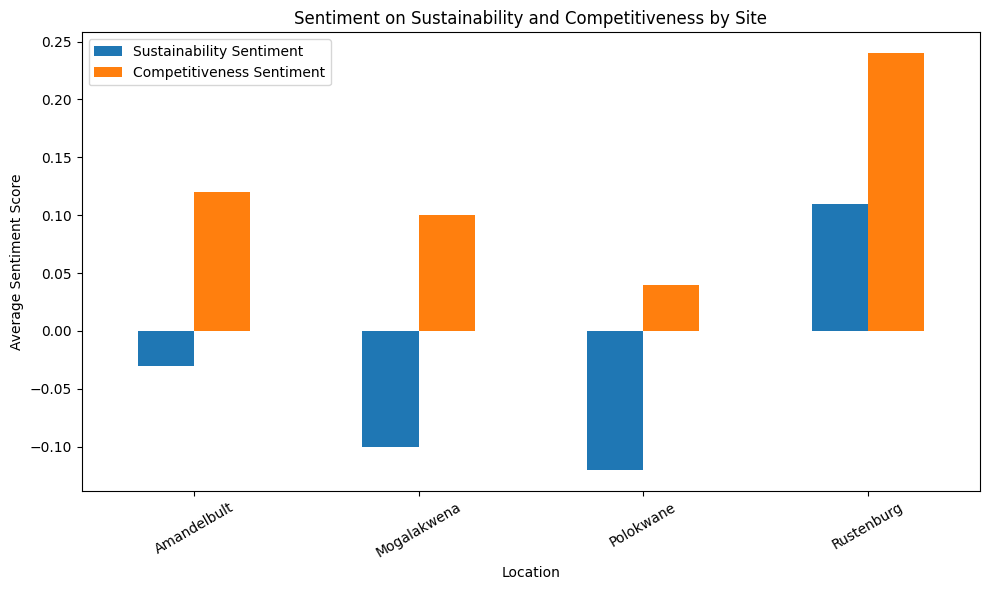


🔍 Top Keywords - Sustainability Issues:
['base' 'business' 'customer' 'customers' 'engagement' 'financial' 'lack'
 'management' 'skills' 'weak']

🔍 Top Keywords - Competitiveness Actions:
['business' 'customer' 'market' 'marketing' 'new' 'offer' 'products'
 'quality' 'service' 'services']

📍 Site-Level Themes - Sustainability:


{'Amandelbult': [('business', 10),
  ('client', 4),
  ('strategy', 3),
  ('value', 2),
  ('proposition', 2)],
 'Mogalakwena': [('skills', 14),
  ('customer', 14),
  ('engagement', 12),
  ('management', 8),
  ('business', 7)],
 'Polokwane': [('skills', 10),
  ('engagement', 8),
  ('customer', 8),
  ('strategic', 4),
  ('management', 4)],
 'Rustenburg': [('business', 8),
  ('client', 6),
  ('financial', 3),
  ('which', 3),
  ('contract', 3)]}


📍 Site-Level Themes - Competitiveness:


{'Amandelbult': [('market', 4),
  ('trends', 3),
  ('product', 3),
  ('business', 3),
  ('engaging', 2)],
 'Mogalakwena': [('service', 9),
  ('services', 8),
  ('market', 7),
  ('products', 7),
  ('quality', 6)],
 'Polokwane': [('marketing', 4),
  ('skills', 4),
  ('training', 3),
  ('strategic', 3),
  ('management', 3)],
 'Rustenburg': [('service', 6),
  ('provide', 3),
  ('client', 3),
  ('business', 3),
  ('providing', 2)]}

In [ ]:
# SECTION 1: QUALITATIVE ANALYSIS – Sustainability and Competitiveness Insights

# Ensure relevant columns are available
qual_cols = [
    'Location:',
    'What issues affect sustainability in the business?',
    'What is the SME doing to ensure it remains competitive/relevant?'
]
df_qual = df[qual_cols].dropna()
df_qual.columns = ['Location', 'Sustainability', 'Competitiveness']

# --- Sentiment Analysis ---
df_qual['Sustainability Sentiment'] = df_qual['Sustainability'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
df_qual['Competitiveness Sentiment'] = df_qual['Competitiveness'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

# --- Average sentiment by site ---
sentiment_summary = df_qual.groupby('Location')[['Sustainability Sentiment', 'Competitiveness Sentiment']].mean().round(2)
print("📊 Sentiment Scores by Site:")
display(sentiment_summary)

# --- Visualize Sentiment Scores ---
sentiment_summary.plot(kind='bar', figsize=(10, 6), title='Sentiment on Sustainability and Competitiveness by Site')
plt.ylabel("Average Sentiment Score")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

# --- Thematic Keyword Extraction ---
def extract_keywords(text_series, top_n=10):
    text = ' '.join(text_series.dropna().astype(str))
    vec = CountVectorizer(stop_words='english', max_features=top_n)
    X = vec.fit_transform([text])
    return vec.get_feature_names_out()

# Top sustainability issues
print("\n🔍 Top Keywords - Sustainability Issues:")
sustainability_keywords = extract_keywords(df_qual['Sustainability'])
print(sustainability_keywords)

# Top competitiveness themes
print("\n🔍 Top Keywords - Competitiveness Actions:")
competitiveness_keywords = extract_keywords(df_qual['Competitiveness'])
print(competitiveness_keywords)

# --- Site-level keyword frequency (optional deep dive) ---
def site_keywords(df, column):
    keywords_by_site = {}
    for site, group in df.groupby('Location'):
        all_text = ' '.join(group[column].dropna().astype(str))
        blob = TextBlob(all_text)
        keywords = [word.lower() for word in blob.words if len(word) > 4]
        top_keywords = Counter(keywords).most_common(5)
        keywords_by_site[site] = top_keywords
    return keywords_by_site

print("\n📍 Site-Level Themes - Sustainability:")
display(site_keywords(df_qual, 'Sustainability'))

print("\n📍 Site-Level Themes - Competitiveness:")
display(site_keywords(df_qual, 'Competitiveness'))


In [ ]:
# @title SECTION 2: Business Efficiencies and Capabilities



📊 STRENGTHS CLUSTER: Percentage Distribution by Industry


,Very Weak,Weak,Moderate,Strong,Very Strong
Industry,,,,,
Energy And Fuel Services,0,0,4,0,0
Ground Preparation And Excavation,0,1,8,0,4
Hospitality And Support Services,0,15,24,0,3
Ict And Digital Services,0,3,3,0,1
Infrastructure And Engineering,0,21,32,0,7
Manufacturing And Industrial,0,2,13,0,3
Security Services,0,1,5,0,0
Transport And Tourism,0,2,7,0,0
Utilities And Technical Services,0,2,13,0,2


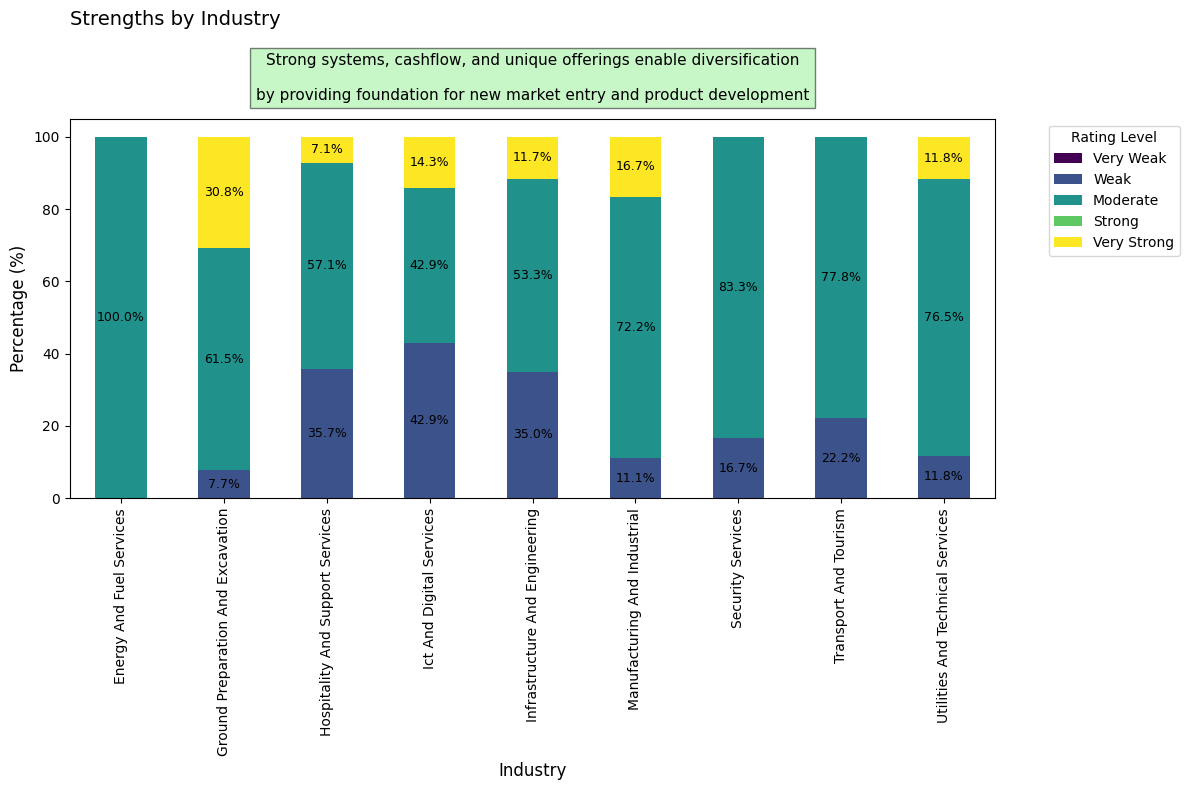


 
💪 Strength-Opportunity Index (Higher = Better Diversification Potential)


,Diversification Potential
Industry,
Infrastructure And Engineering,3.5
Ground Preparation And Excavation,2.0
Hospitality And Support Services,1.5
Manufacturing And Industrial,1.5
Utilities And Technical Services,1.0
Ict And Digital Services,0.5
Energy And Fuel Services,0.0
Security Services,0.0
Transport And Tourism,0.0



📊 STRENGTHS CLUSTER: Percentage Distribution by Location


,Very Weak,Weak,Moderate,Strong,Very Strong
Location,,,,,
Amandelbult,0,6,30,0,3
Mogalakwena,0,23,43,0,12
Polokwane,0,10,12,0,4
Rustenburg,0,8,24,0,1


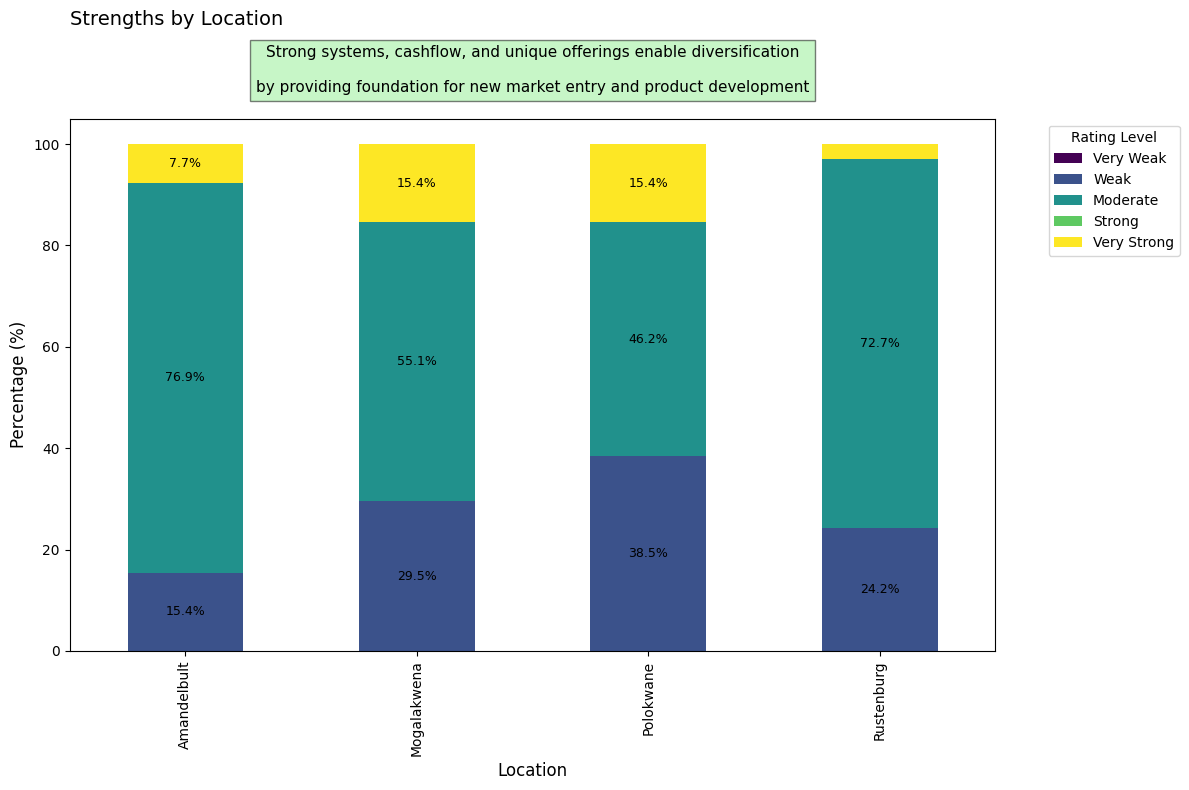


📊 WEAKNESSES CLUSTER: Percentage Distribution by Industry


,Very Weak,Weak,Moderate,Strong,Very Strong
Industry,,,,,
Energy And Fuel Services,0,0,1,0,0
Ground Preparation And Excavation,0,0,8,0,0
Hospitality And Support Services,0,0,18,0,0
Ict And Digital Services,0,0,4,0,0
Infrastructure And Engineering,0,0,44,0,0
Manufacturing And Industrial,0,0,15,0,0
Security Services,0,0,6,0,0
Transport And Tourism,0,0,6,0,0
Utilities And Technical Services,0,0,11,0,0


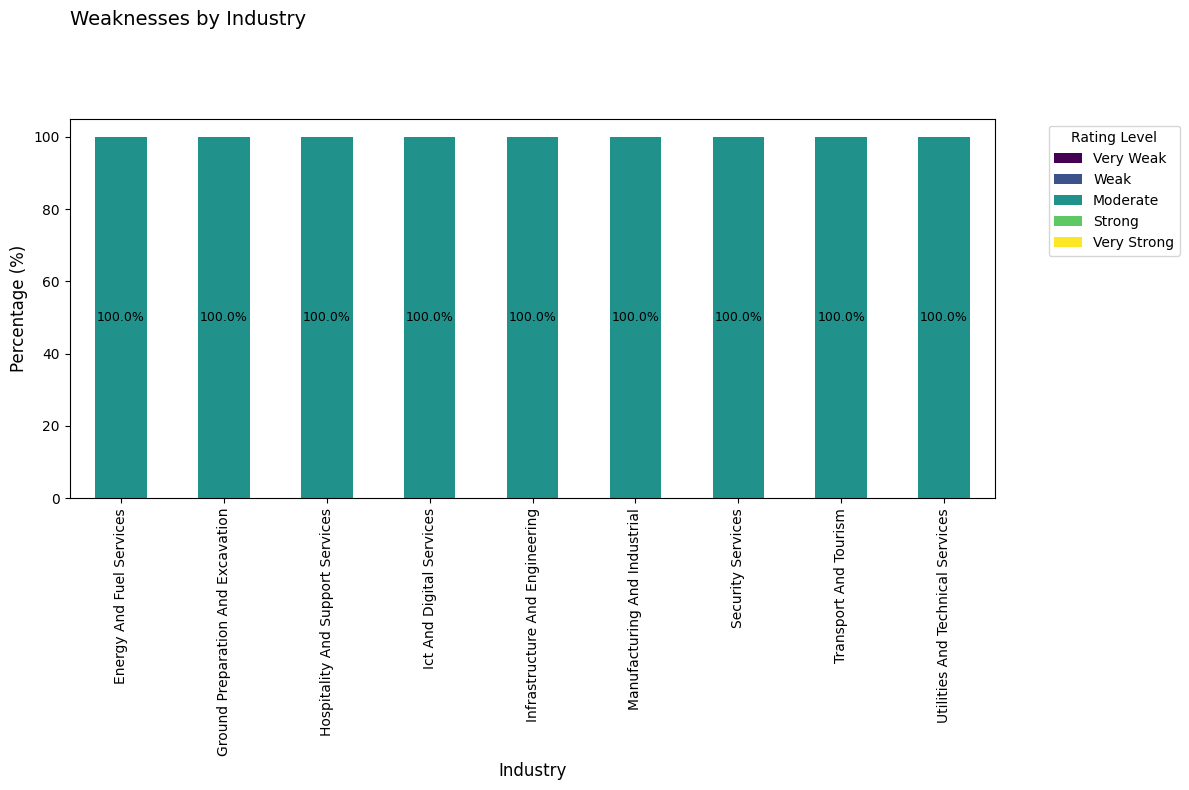


📊 WEAKNESSES CLUSTER: Percentage Distribution by Location


,Very Weak,Weak,Moderate,Strong,Very Strong
Location,,,,,
Amandelbult,0,0,31,0,0
Mogalakwena,0,0,41,0,0
Polokwane,0,0,12,0,0
Rustenburg,0,0,29,0,0


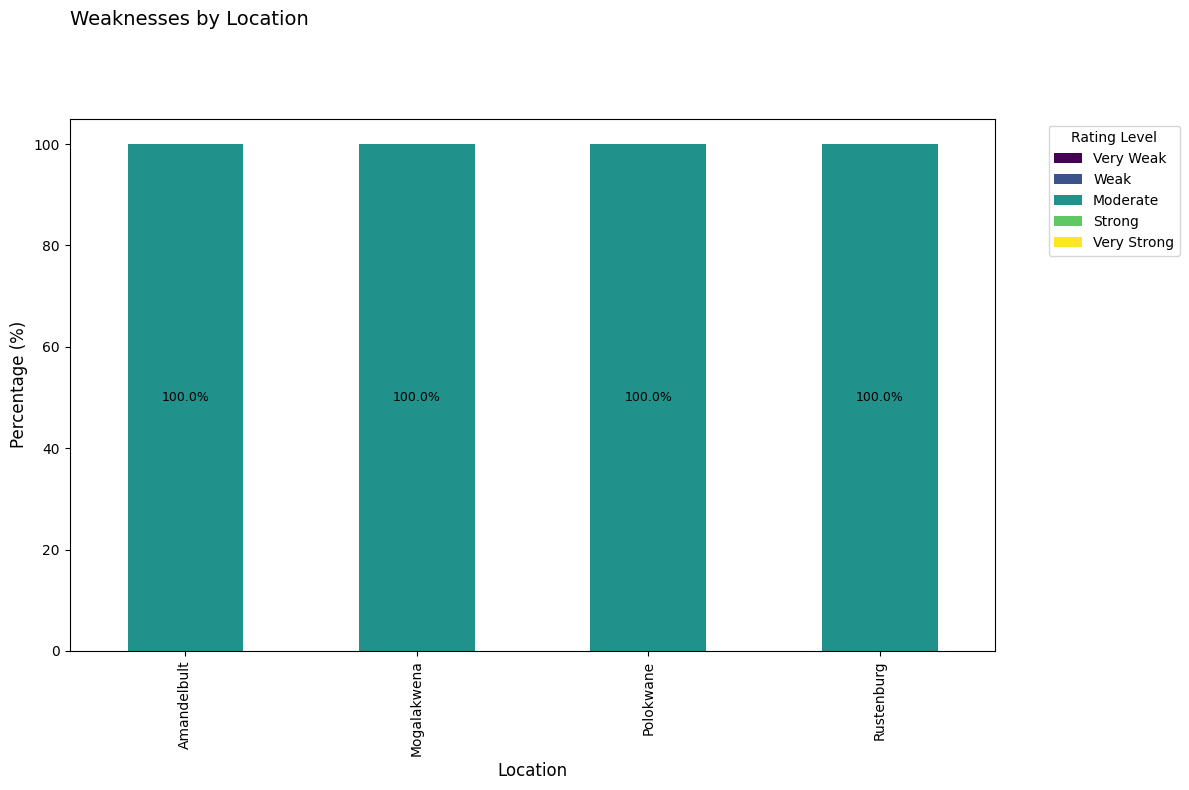


📊 OPPORTUNITIES CLUSTER: Percentage Distribution by Industry


,Very Weak,Weak,Moderate,Strong,Very Strong
Industry,,,,,
Energy And Fuel Services,0,0,0,0,0
Ground Preparation And Excavation,0,0,0,0,0
Hospitality And Support Services,0,0,6,0,0
Ict And Digital Services,0,0,1,0,0
Infrastructure And Engineering,0,0,11,0,0
Manufacturing And Industrial,0,0,3,0,0
Security Services,0,0,1,0,0
Transport And Tourism,0,0,5,0,0
Utilities And Technical Services,0,0,4,0,0


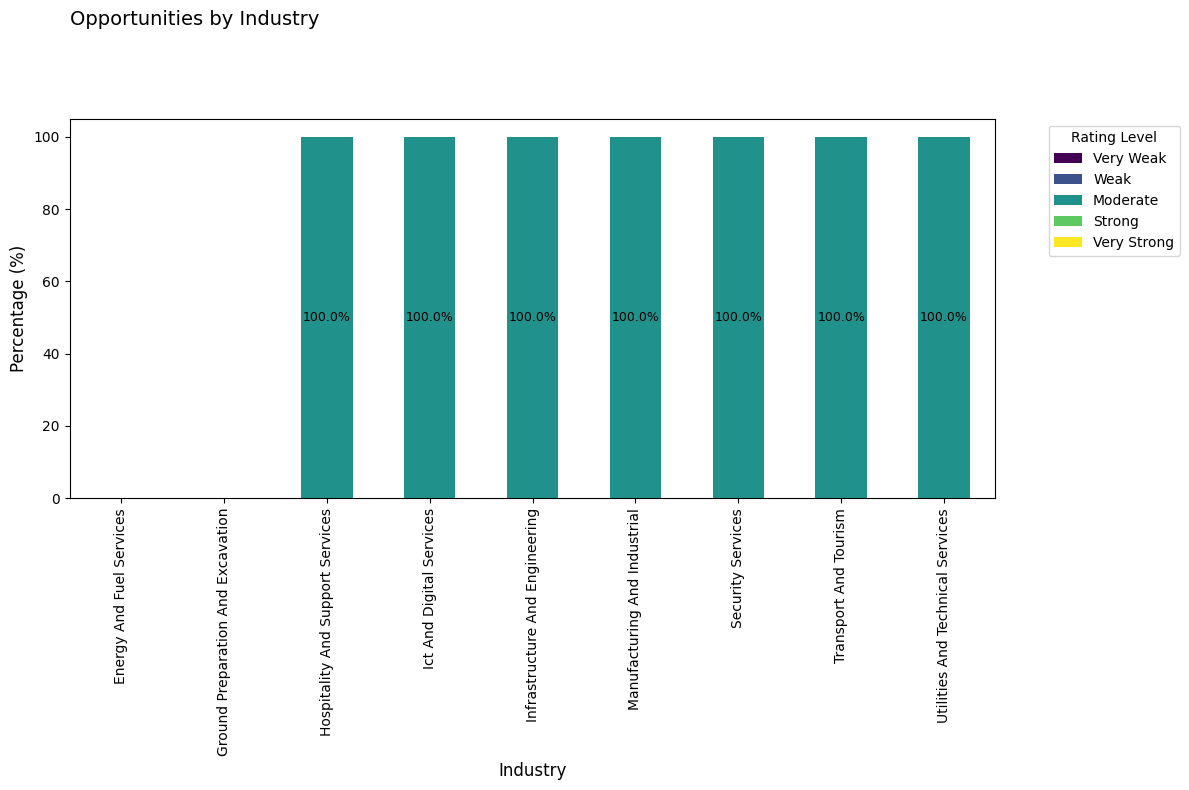


📊 OPPORTUNITIES CLUSTER: Percentage Distribution by Location


,Very Weak,Weak,Moderate,Strong,Very Strong
Location,,,,,
Amandelbult,0,0,12,0,0
Mogalakwena,0,0,10,0,0
Polokwane,0,0,2,0,0
Rustenburg,0,0,7,0,0


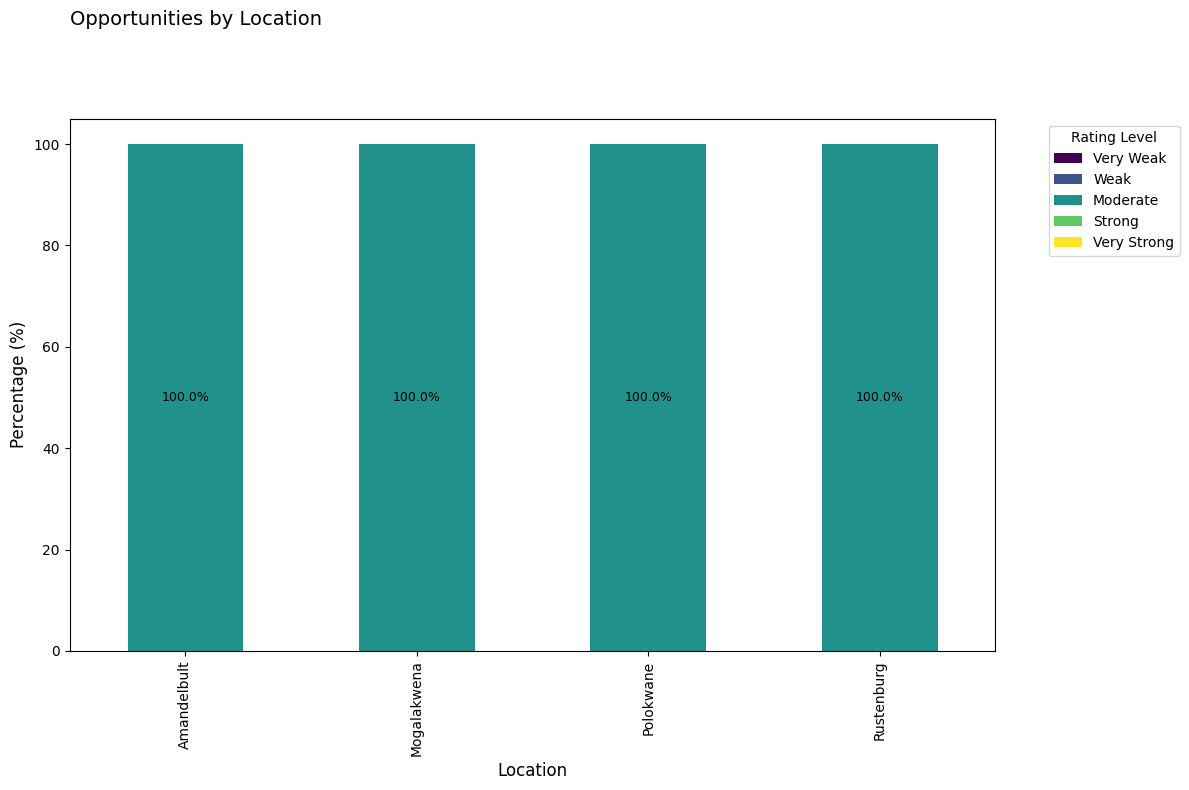


📊 THREATS CLUSTER: Percentage Distribution by Industry


,Very Weak,Weak,Moderate,Strong,Very Strong
Industry,,,,,
Energy And Fuel Services,0,0,2,0,0
Ground Preparation And Excavation,0,0,4,0,0
Hospitality And Support Services,0,0,11,0,0
Ict And Digital Services,0,0,0,0,0
Infrastructure And Engineering,0,0,28,0,0
Manufacturing And Industrial,0,0,10,0,0
Security Services,0,0,3,0,0
Transport And Tourism,0,0,10,0,0
Utilities And Technical Services,0,0,10,0,0


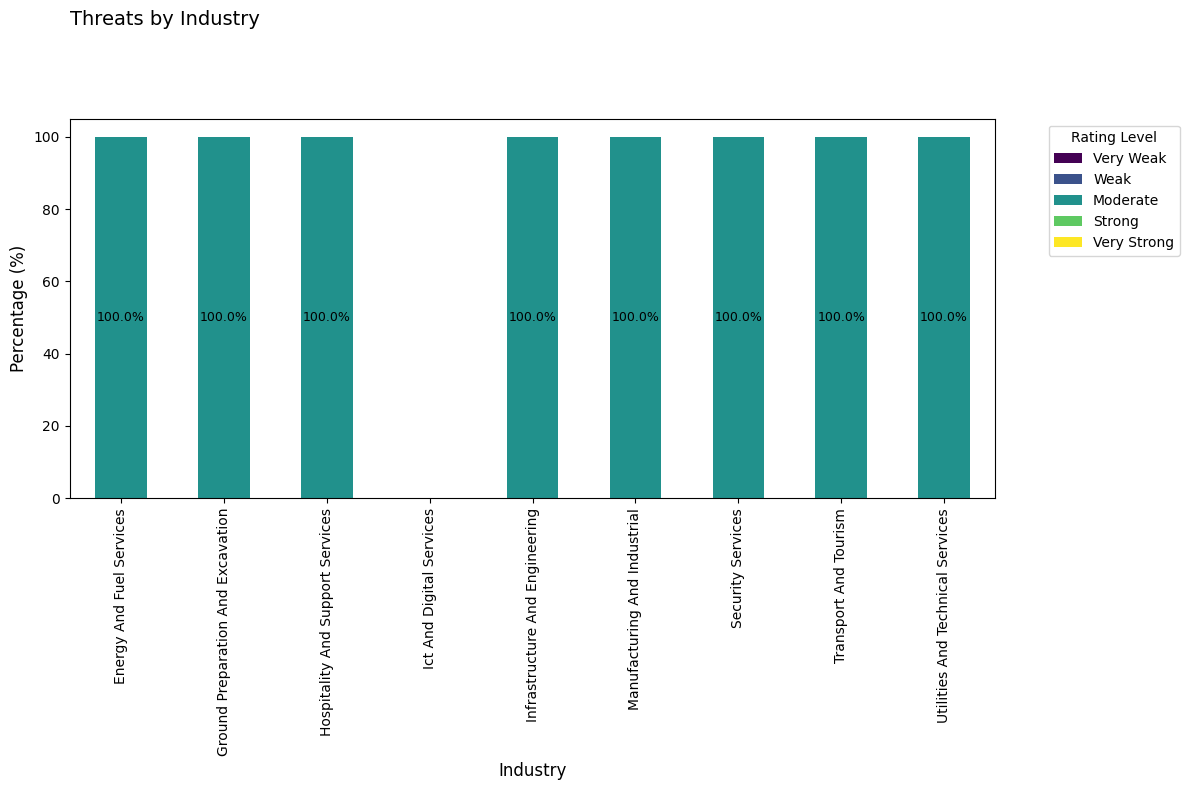


📊 THREATS CLUSTER: Percentage Distribution by Location


,Very Weak,Weak,Moderate,Strong,Very Strong
Location,,,,,
Amandelbult,0,0,20,0,0
Mogalakwena,0,0,31,0,0
Polokwane,0,0,11,0,0
Rustenburg,0,0,16,0,0


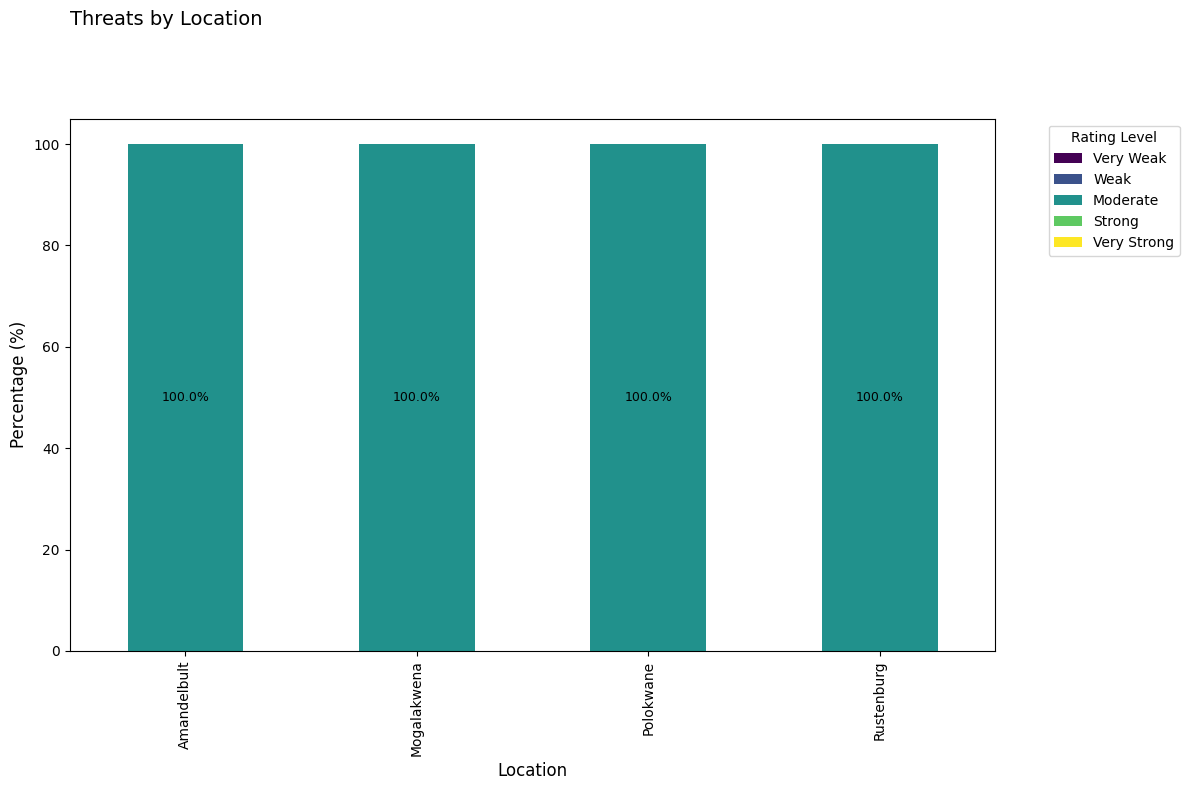

In [ ]:
# Define clusters and rating mappings
clusters = {
    'Strengths': ['Good Systems', 'Strong Cashflow', 'Expert Skills', 'Unique product or service'],
    'Weaknesses': ['Lack of funding', 'Lack of tenders', 'High Staff turnover', 'Stiff market competition', 'Alternative products/services in the market'],
    'Opportunities': ['New product lines', 'Other business (different sector)'],
    'Threats': ['Loss of largest customer', 'Ease of entry into new market', 'Change in technology', 'Changing customer preferrences']
}

rating_map = {
    'Very Weak': 0,
    'Weak': 1,
    'Moderate': 2,
    'Strong': 3,
    'Very Strong': 4
}

# Map ratings to numeric values
def map_ratings(df, columns):
    for col in columns:
        if col in df.columns:
            df[col] = df[col].astype(str).str.strip().map(rating_map)
    return df

def plot_stacked_percentage(data, title, cluster_type):
    """Plot stacked percentage bar chart for better visualization"""
    data_perc = data.div(data.sum(axis=1), axis=0) * 100

    fig, ax = plt.subplots(figsize=(12, 8))
    data_perc.plot(kind='bar', stacked=True, ax=ax, colormap='viridis')

    plt.title(f"{title}\n\n\n", fontsize=14,  loc='left', pad=20)
    plt.ylabel("Percentage (%)", fontsize=12)
    plt.xlabel(data.index.name if data.index.name else "", fontsize=12)

    # Add percentage labels
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        if height > 5:  # Only show labels for segments >5%
            x, y = p.get_xy()
            ax.annotate(f'{height:.1f}%', (x + width/2, y + height/2),
                        ha='center', va='center', fontsize=9)

    # Highlight how strengths can enable diversification (only for Strengths cluster)
    if cluster_type == 'Strengths':
        ax.text(0.5, 1.05,
                "Strong systems, cashflow, and unique offerings enable diversification\n \nby providing foundation for new market entry and product development",
                transform=ax.transAxes, ha='center', fontsize=11,
                bbox=dict(facecolor='lightgreen', alpha=0.5))

    plt.legend(title='Rating Level', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

def analyze_clusters_improved(df, clusters):
    """Improved analysis with percentage visualizations and diversification insights"""
    for cluster_type, cols in clusters.items():
        df_copy = df[['Industry/Sector of the business', 'Location:'] + cols].copy()
        df_copy = map_ratings(df_copy, cols)

        # Create rating level columns for percentage visualization
        rating_levels = ['Very Weak', 'Weak', 'Moderate', 'Strong', 'Very Strong']

        # Analyze by Industry
        industry_data = []
        for industry, group in df_copy.groupby('Industry/Sector of the business'):
            counts = []
            for col in cols:
                rating_counts = group[col].value_counts().reindex(range(5), fill_value=0)
                counts.append(rating_counts)
            industry_counts = pd.concat(counts, axis=1).sum(axis=1)
            industry_data.append(industry_counts.rename(industry))

        if industry_data:
            industry_summary = pd.concat(industry_data, axis=1).T
            industry_summary.columns = rating_levels
            industry_summary.index.name = 'Industry'

            print(f"\n📊 {cluster_type.upper()} CLUSTER: Percentage Distribution by Industry")
            display(industry_summary)

            plot_stacked_percentage(industry_summary,
                                   f"{cluster_type} by Industry",
                                   cluster_type)

            # Calculate and display strength-opportunity index for diversification
            if cluster_type == 'Strengths':
                strength_index = industry_summary[['Strong', 'Very Strong']].mean(axis=1)
                print("\n \n💪 Strength-Opportunity Index (Higher = Better Diversification Potential)")
                display(pd.DataFrame(strength_index, columns=['Diversification Potential']).sort_values(by='Diversification Potential', ascending=False))

        # Analyze by Location
        location_data = []
        for location, group in df_copy.groupby('Location:'):
            counts = []
            for col in cols:
                rating_counts = group[col].value_counts().reindex(range(5), fill_value=0)
                counts.append(rating_counts)
            location_counts = pd.concat(counts, axis=1).sum(axis=1)
            location_data.append(location_counts.rename(location))

        if location_data:
            location_summary = pd.concat(location_data, axis=1).T
            location_summary.columns = rating_levels
            location_summary.index.name = 'Location'

            print(f"\n📊 {cluster_type.upper()} CLUSTER: Percentage Distribution by Location")
            display(location_summary)

            plot_stacked_percentage(location_summary,
                                  f"{cluster_type} by Location",
                                  cluster_type)

# ✅ To use this, make sure your DataFrame is named `df`
# Then simply call:
analyze_clusters_improved(df, clusters)

📊 Aggregate Average Skills Gaps (0 = No Gap, 4 = Serious Gap):


,0
Financial Management,2.56
Marketing and Sales,2.31
Human Resources,2.22
Supply Chain & Procurement,1.97
Business Management,1.91
Project Management,1.64
Customer Service,1.61
Regulatory & Compliance,1.45


📍 Site-Specific Average Skills Gaps:


,Financial Management,Business Management,Marketing and Sales,Human Resources,Customer Service,Regulatory & Compliance,Supply Chain & Procurement,Project Management
Location:,,,,,,,,
Amandelbult,2.50,1.64,2.21,2.29,1.43,1.86,2.36,1.71
Mogalakwena,2.37,1.67,2.22,2.15,1.52,1.07,1.67,1.56
Polokwane,3.11,2.22,2.11,2.22,1.56,1.67,1.67,1.56
Rustenburg,2.64,2.43,2.71,2.29,2.00,1.64,2.36,1.79


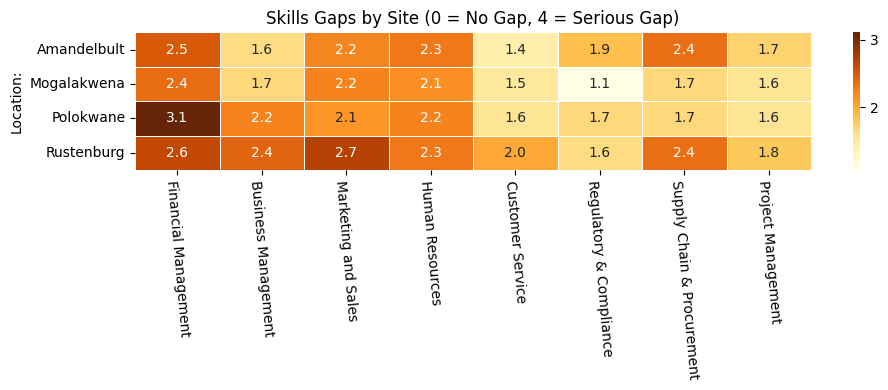

In [ ]:
# @title SECTION 3: Skills and Capabilities (Corrected)

# Define skill column labels (from your Excel sheet)
skills_columns = {
    "Financial Management": "Financial Management",
    "Business Management": "Business Management",
    "Marketing and Sales": "Marketing and Sales2",
    "Human Resources": "Human Resources",
    "Customer Service": "Customer Services",
    "Regulatory & Compliance": "Regulatory and Compliance",
    "Supply Chain & Procurement": "Supply Chain (procurement)",
    "Project Management": "Project Management"
}

# Map categorical skill gap responses to numeric values
gap_scale = {
    'no gap': 0,
    'negligible gap': 1,
    'moderate': 2,
    'identified gap': 3,
    'serious gap': 4
}

# Select relevant columns from the dataset
skills_df = df[['Location:'] + list(skills_columns.values())].copy()

# Normalize and convert skill gap categories to numeric
for col in skills_columns.values():
    skills_df[col] = skills_df[col].astype(str).str.strip().str.lower().map(gap_scale)

# --- Aggregate: Average skill gap levels across all SMEs ---
skills_gap_avg = skills_df[skills_columns.values()].mean().round(2)
skills_gap_avg.index = list(skills_columns.keys())

print("📊 Aggregate Average Skills Gaps (0 = No Gap, 4 = Serious Gap):")
display(skills_gap_avg.sort_values(ascending=False))

# --- Site-specific analysis ---
site_gap_avg = skills_df.groupby('Location:')[list(skills_columns.values())].mean().round(2)
site_gap_avg.columns = list(skills_columns.keys())

print("📍 Site-Specific Average Skills Gaps:")
display(site_gap_avg)

# Ensure the site_gap_avg columns are explicitly reordered to match the skills_columns keys
ordered_columns = list(skills_columns.keys())
site_gap_avg = site_gap_avg[ordered_columns]

# --- Clean and plot heatmap ---
site_gap_clean = site_gap_avg.apply(pd.to_numeric, errors='coerce').dropna(how='all').dropna(axis=1, how='all')

if not site_gap_clean.empty:
    plt.figure(figsize=(10, max(4, len(site_gap_clean) * 0.6)))
    sns.heatmap(site_gap_clean, annot=True, fmt=".1f", cmap="YlOrBr", linewidths=0.5)
    plt.title("Skills Gaps by Site (0 = No Gap, 4 = Serious Gap)")
    plt.xticks(rotation=275)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No valid numeric data to display in heatmap.")

📊 Average Product Share by Site:


,Top Product %,Second Product %,Third Product %
Location,,,
Amandelbult,0.71,0.17,0.08
Mogalakwena,19.26,37.18,18.65
Polokwane,0.90,0.08,0.02
Rustenburg,0.87,0.14,0.03


💰 Total Non-Mining Revenue by Site:


,Non-Mining Revenue
Location,
Mogalakwena,42232240.00
Amandelbult,9700413.10
Polokwane,9127368.00
Rustenburg,3823804.72


🌍 Sales Distribution by Location (%):


Sales Location,In another province,Nationwide,Nearby town,Same town
Location,,,,
Amandelbult,7.1,0.0,35.7,57.1
Mogalakwena,0.0,14.8,25.9,59.3
Polokwane,11.1,33.3,33.3,22.2
Rustenburg,14.3,0.0,14.3,71.4


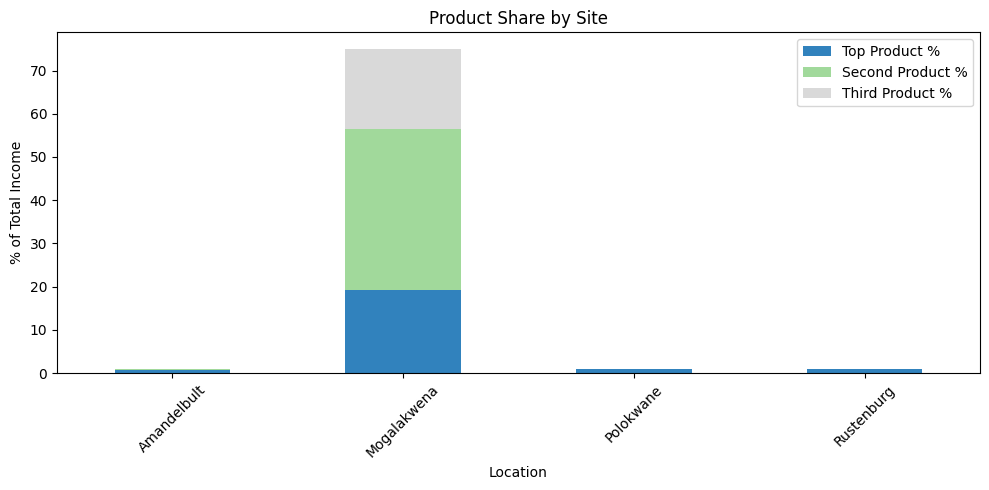

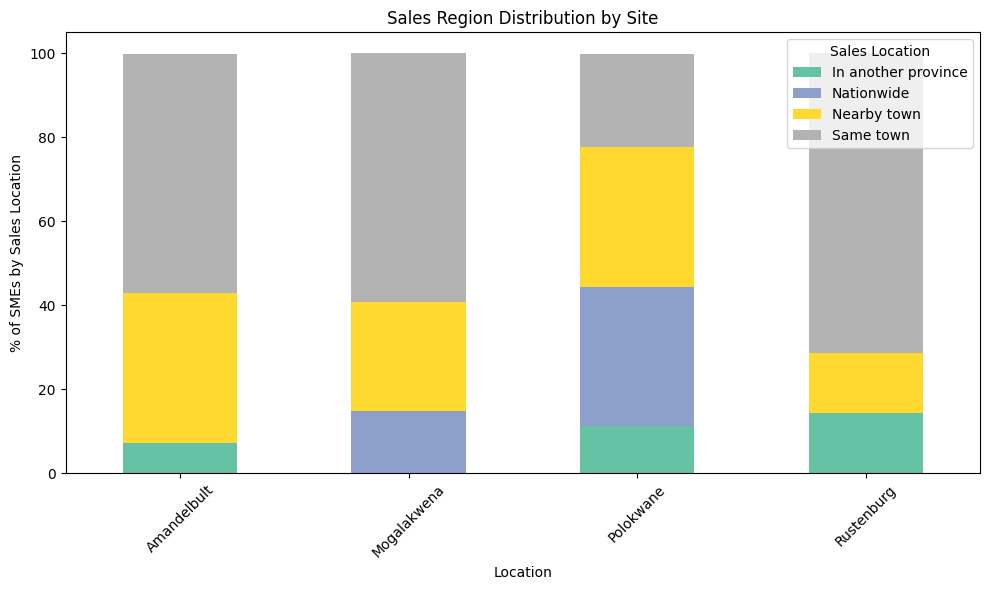

👥 Example Customer Info (First 5):


,Location,Customer Info
0,Mogalakwena,Mogalakwena mine
1,Mogalakwena,Mogalakwena Mine
2,Polokwane,Anglo American Platinum (6712427) Lebalelo Wat...
3,Rustenburg,Alarm & Security Partner 1536243
4,Amandelbult,NON


In [ ]:
# @title SECTION 4: Product and Service Range

# Define relevant columns
product_cols = {
    'Location': 'Location:',
    'Main Product': 'What is your mainline product or service?',
    'Top Product %': 'What is the percentage of the top sales product/service as a fraction of the total income?',
    'Second Product %': 'What is the percentage of the second best product/service as a fraction of the total income?',
    'Third Product %': 'What is the percentage of the third best product/service as a fraction of the total income?',
    'Customer Info': 'List your 3 main customers and how much did you sell to them last FY? example Anglo American (350000) Royal Bafokeng (1000000) Matsatsi (500000)',
    'Non-Mining Revenue': 'What is the total revenue from non-mining sales for the most recent financial year end?',
    'Sales Location': 'Where do you sell most of your products/services?'
}

# Load and prepare data
ps_df = df[list(product_cols.values())].copy()
ps_df.rename(columns={v: k for k, v in product_cols.items()}, inplace=True)

# Convert income % fields to numeric
income_cols = ['Top Product %', 'Second Product %', 'Third Product %']
for col in income_cols + ['Non-Mining Revenue']:
    ps_df[col] = pd.to_numeric(ps_df[col], errors='coerce')

# --- Aggregate Product Share by Site ---
site_summary = ps_df.groupby('Location')[income_cols].mean().round(2)
print("📊 Average Product Share by Site:")
display(site_summary)

# --- Revenue Diversification from Non-Mining ---
nmining_summary = ps_df.groupby('Location')['Non-Mining Revenue'].sum().sort_values(ascending=False)
print("💰 Total Non-Mining Revenue by Site:")
display(nmining_summary)

# --- Add Non-Mining % (Approximate to Top + Second + Third) ---
ps_df['Total Income %'] = ps_df[income_cols].sum(axis=1)
ps_df['Non-Mining % of Income'] = ((ps_df['Non-Mining Revenue'] / ps_df['Non-Mining Revenue'].max()) * 100).round(1)

# --- Sales Location Distribution ---
sales_loc_dist = ps_df.groupby(['Location', 'Sales Location']).size().unstack(fill_value=0)
sales_loc_pct = sales_loc_dist.div(sales_loc_dist.sum(axis=1), axis=0).multiply(100).round(1)
print("🌍 Sales Distribution by Location (%):")
display(sales_loc_pct)

# --- Plots ---
site_summary.plot(kind='bar', stacked=True, figsize=(10, 5), colormap='tab20c', title="Product Share by Site")
plt.ylabel("% of Total Income")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

sales_loc_pct.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='Set2', title="Sales Region Distribution by Site")
plt.ylabel("% of SMEs by Sales Location")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- Optional: Display sample customer info (summarised) ---
print("👥 Example Customer Info (First 5):")
display(ps_df[['Location', 'Customer Info']].dropna().head())


📊 Aggregate Diversification Indicators (% SMEs):


,0
Ready Market,89.1
Sales Plan,67.2
New Product Plan,45.3
Market Research,39.1
New Markets,31.2
Started Venture,29.7
Business Plan,25.0
Financial Resources,14.1


📍 Diversification Indicators by Site (% SMEs):


,Market Research,New Markets,Sales Plan,New Product Plan,Started Venture,Financial Resources,Business Plan,Ready Market
Location:,,,,,,,,
Amandelbult,28.6,21.4,64.3,35.7,50.0,0.0,35.7,92.9
Mogalakwena,48.1,33.3,70.4,63.0,22.2,7.4,22.2,85.2
Polokwane,33.3,44.4,77.8,33.3,22.2,33.3,11.1,88.9
Rustenburg,35.7,28.6,57.1,28.6,28.6,28.6,28.6,92.9


<Figure size 1000x600 with 0 Axes>

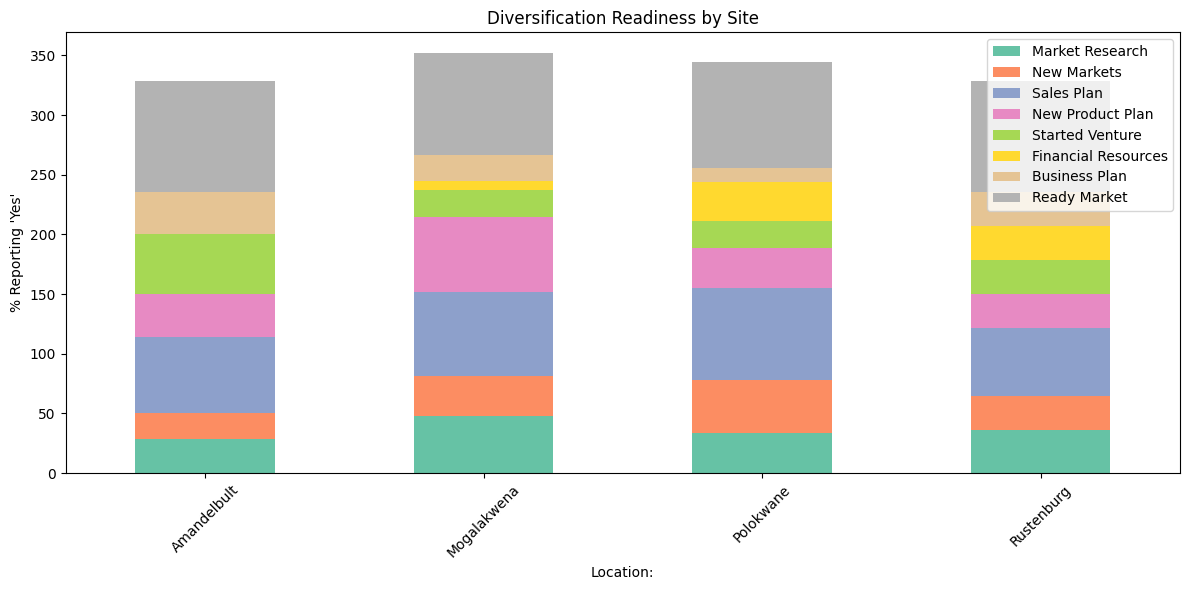


📝 New Product Details Themes for Amandelbult: ['transportation', 'business', 'truck', 'current', 'cement', 'surveillance', 'systems', 'thabazimbi', 'section', 'repair']

📝 New Product Details Themes for Mogalakwena: ['supply', 'sharing', 'training', 'planning', 'concrete', 'wants', 'print', 'allow', 'business', 'service']

📝 New Product Details Themes for Polokwane: ['services', 'welding', 'repairs', 'structural', 'maintenance', 'coding', 'training', 'technicians', 'started', 'strip']

📝 New Product Details Themes for Rustenburg: ['services', 'process', 'supply', 'business', 'management', 'cleaning', 'meals', 'products', 'steel', 'other']

📝 Support Required Themes for Amandelbult: ['funding', 'market', 'linkages', 'equipment']

📝 Support Required Themes for Mogalakwena: ['funding', 'market', 'linkages', 'equipment', 'training']

📝 Support Required Themes for Polokwane: ['funding', 'market', 'linkages', 'training']

📝 Support Required Themes for Rustenburg: ['market', 'linkages', 'equ

{'Amandelbult': [('access', 12),
  ('funding', 10),
  ('market', 2),
  ('technology', 2)],
 'Mogalakwena': [('access', 25),
  ('funding', 16),
  ('market', 9),
  ('skills', 2)],
 'Polokwane': [('access', 6), ('funding', 4), ('skills', 3), ('market', 2)],
 'Rustenburg': [('access', 13),
  ('market', 10),
  ('funding', 3),
  ('competition', 1)]}

In [ ]:
# @title SECTION 5: Tracking for Diversification

# Define relevant column mappings
div_cols = {
    "Market Research": "Has the SME conducted a market assessment or research in the last 6 months?",
    "New Markets": "Have you accessed new markets in the past 12 months?",
    "New Market Specified": "If yes, please specify the new market entered:",
    "Sales Plan": "Does the SME have a sales plan or value proposition in place?",
    "New Product Plan": "Does the business plan to introduce new products/services in the next 12 months?",
    "New Product Details": "What are your planned \"new\" products or services?",
    "Started Venture": "Have you started on this venture yet?",
    "Financial Resources": "Do you have financial resources available for expansion?",
    "Amount Invested": "How much have you invested in the venture so far?",
    "Business Plan": "Have you prepared a business plan already?",
    "Ready Market": "Is there a ready market for the product/service?",
    "Clients": "Who would be the biggest clients for this product or service?",
    "Time to Establish": "How many months would it take to establish this venture?",
    "Challenges": "What challenges/barriers have you identified so far with this venture? choose all relevant",
    "Support Required": "What support do you require for this business idea?",
}

# Create working DataFrame
div_df = df[['Location:'] + list(div_cols.values())].copy()

# Normalize Yes/No responses
yes_vals = ['yes', 'y', '✔', '✓', 'true', '1']
def normalize_binary(col):
    return col.astype(str).str.strip().str.lower().apply(lambda x: 1 if x in yes_vals else 0)

quantitative_fields = [
    "Market Research", "New Markets", "Sales Plan", "New Product Plan",
    "Started Venture", "Financial Resources", "Business Plan", "Ready Market"
]

# Apply normalization
for field in quantitative_fields:
    div_df[field] = normalize_binary(div_df[div_cols[field]])

# --- Aggregate Data ---
agg_pct = div_df[quantitative_fields].mean().multiply(100).round(1).sort_values(ascending=False)
print("📊 Aggregate Diversification Indicators (% SMEs):")
display(agg_pct)

# --- Site-specific Data ---
site_pct = div_df.groupby('Location:')[quantitative_fields].mean().multiply(100).round(1)
print("📍 Diversification Indicators by Site (% SMEs):")
display(site_pct)

# --- Visualization ---
plt.figure(figsize=(10, 6))
site_pct.plot(kind='bar', stacked=True, colormap='Set2', figsize=(12, 6))
plt.title("Diversification Readiness by Site")
plt.ylabel("% Reporting 'Yes'")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- Thematic Analysis Function ---
def thematic_analysis(col_key):
    column = div_cols[col_key]
    results = {}
    for site, group in div_df.groupby("Location:"):
        text = ' '.join(group[column].dropna().astype(str))
        blob = TextBlob(text)
        keywords = [w.lower() for w in blob.words if len(w) > 4]
        themes = Counter(keywords).most_common(10)
        results[site] = themes
        print(f"\n📝 {col_key} Themes for {site}: {[kw for kw, _ in themes]}")
    return results

# Run Thematic Analysis
thematic_analysis("New Product Details")
thematic_analysis("Support Required")
thematic_analysis("Challenges")


📊 Table 21: Partnership Engagement by Site


,Engaged,Signed Agreements,Interested
Location,,,
Amandelbult,10,2,8
Mogalakwena,28,3,21
Polokwane,8,2,6
Rustenburg,11,4,9
Total,57,11,44


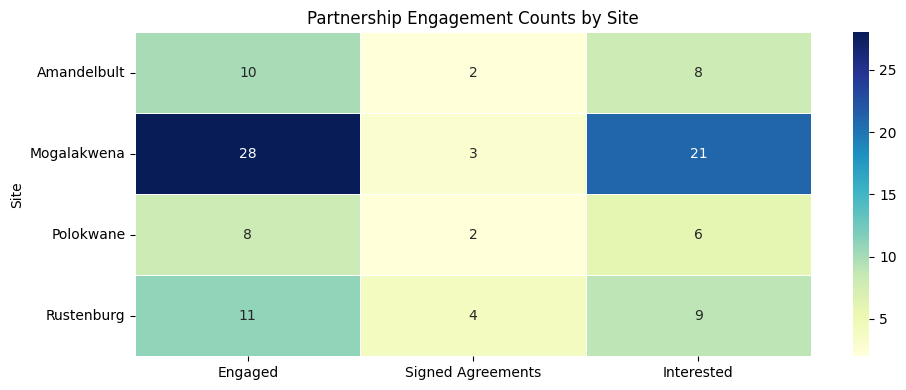

In [ ]:
# --- Normalize column names ---
df.columns = df.columns.str.strip()

# --- Define relevant column mappings ---
partnership_columns = {
    "Engaged": "How many partnerships has the SME engaged for business growth",
    "Signed Agreements": "Is there a signed agreement in place for the partnership?",
    "Interested": "If no partnership in place, does the SME have interest in partnerships to grow the business?"
}

# --- Extract and rename relevant columns ---
partnership_df = df[['Location:'] + list(partnership_columns.values())].copy()
partnership_df.columns = ['Location'] + list(partnership_columns.keys())

# --- Clean Yes/No responses ---
yes_vals = ['yes', '1']
no_vals = ['no', '0']

for col in ['Signed Agreements', 'Interested']:
    partnership_df[col] = partnership_df[col].astype(str).str.lower().str.strip()
    partnership_df[col] = partnership_df[col].apply(lambda x: 1 if x in yes_vals else 0 if x in no_vals else pd.NA)

# --- Convert 'Engaged' to numeric safely ---
partnership_df['Engaged'] = pd.to_numeric(partnership_df['Engaged'], errors='coerce')

# --- Group by Location and sum ---
agg_partnerships = partnership_df.groupby('Location')[['Engaged', 'Signed Agreements', 'Interested']].sum().astype(int)

# --- Add totals row ---
agg_partnerships.loc['Total'] = agg_partnerships.sum()

# --- Display the final table (like Table 21) ---
print("📊 Table 21: Partnership Engagement by Site")
display(agg_partnerships)

# --- Optional: Plot as heatmap (counts) ---
plt.figure(figsize=(10, max(4, len(agg_partnerships) * 0.6)))
sns.heatmap(agg_partnerships.drop(index='Total'), annot=True, cmap='YlGnBu', fmt="d", linewidths=0.5)
plt.title("Partnership Engagement Counts by Site")
plt.ylabel("Site")
plt.tight_layout()
plt.show()


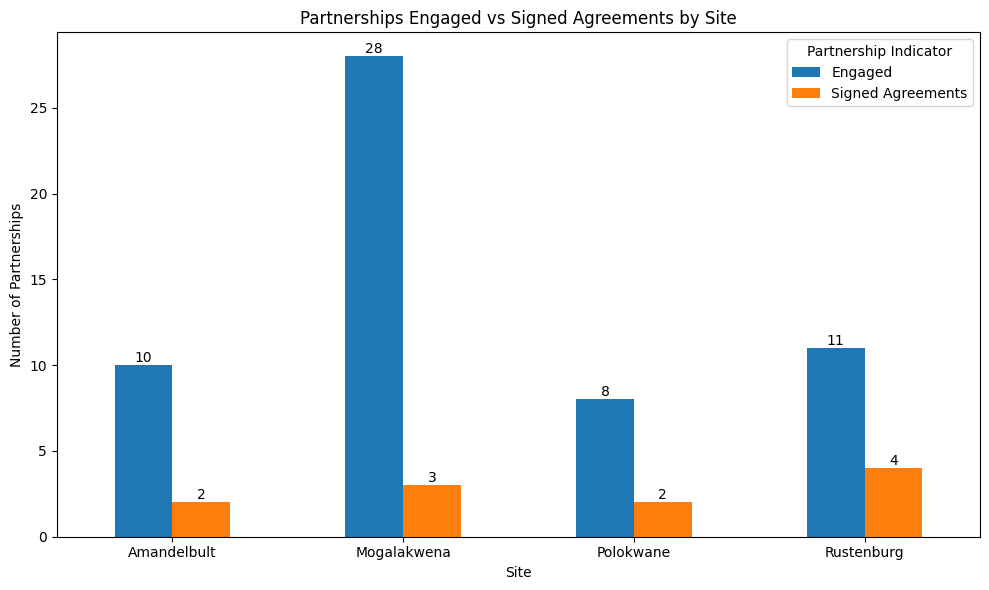

In [ ]:
# --- Filter out the 'Total' row for plotting ---
bar_data = agg_partnerships.drop(index='Total')[['Engaged', 'Signed Agreements']]

# --- Plot bar chart ---
ax = bar_data.plot(kind='bar', figsize=(10, 6), color=['#1f77b4', '#ff7f0e'])
plt.title("Partnerships Engaged vs Signed Agreements by Site")
plt.ylabel("Number of Partnerships")
plt.xlabel("Site")
plt.xticks(rotation=0)
plt.legend(title="Partnership Indicator")

# --- Add count labels on top of bars ---
for p in ax.patches:
    height = p.get_height()
    if not pd.isna(height) and height > 0:
        ax.annotate(f'{int(height)}',
                    (p.get_x() + p.get_width() / 2, height),
                    ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


# INDICATORS FROM LOGFRAME WORK

In [ ]:
# @title calculate logframe indicator values from the baseline tool

import pandas as pd

# Load and clean dataset
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

# Sample indicators calculated from the cleaned DataFrame

# 1. % SMEs with Net Profit (assume 'npat' or similar exists)
if 'npat' in df.columns:
    net_profit_pct = (df['npat'] > 0).mean() * 100
else:
    net_profit_pct = None

# 2. % SMEs with multiple income streams (assume columns like 'product_2_pct', 'product_3_pct')
product_cols = [col for col in df.columns if 'product' in col and '_pct' in col]
multi_income_pct = (df[product_cols].fillna(0).gt(0).sum(axis=1) > 1).mean() * 100

# 3. % with business plans (assume 'business_plan' is binary or yes/no)
bp_col = [col for col in df.columns if 'business_plan' in col]
if bp_col:
    business_plan_pct = (df[bp_col[0]].astype(str).str.lower().isin(['yes', '1', 'true'])).mean() * 100
else:
    business_plan_pct = None

# 4. % with sales plans
sales_plan_col = [col for col in df.columns if 'sales_plan' in col]
if sales_plan_col:
    sales_plan_pct = (df[sales_plan_col[0]].astype(str).str.lower().isin(['yes', '1', 'true'])).mean() * 100
else:
    sales_plan_pct = None

# 5. % engaged in partnerships (assume 'partnership_engaged' column exists)
partnership_col = [col for col in df.columns if 'engaged' in col or 'partnership' in col]
if partnership_col:
    partnership_pct = (df[partnership_col[0]].astype(str).str.lower().isin(['yes', '1', 'true'])).mean() * 100
else:
    partnership_pct = None

# 6. % accessing new markets (assume 'new_market' column)
market_col = [col for col in df.columns if 'new_market' in col]
if market_col:
    new_market_pct = (df[market_col[0]].astype(str).str.lower().isin(['yes', '1', 'true'])).mean() * 100
else:
    new_market_pct = None

# 7. Avg # partnerships per SME (assume partnership count fields exist)
partnership_count_cols = [col for col in df.columns if 'partnership_' in col and 'count' in col]
if partnership_count_cols:
    avg_partnerships = df[partnership_count_cols].fillna(0).sum(axis=1).mean()
else:
    avg_partnerships = None

# 8. Avg financial skills gap (e.g., 'skills_financial_management')
skills_col = [col for col in df.columns if 'financial' in col and 'skills' in col]
if skills_col:
    avg_fin_skills_gap = df[skills_col[0]].mean()
else:
    avg_fin_skills_gap = None

# 9. % ready to diversify (e.g., ready_market + new_product_plan)
div_ready_cols = [col for col in df.columns if 'ready_market' in col or 'new_product_plan' in col]
if div_ready_cols:
    div_ready_pct = (df[div_ready_cols].apply(lambda row: any(str(val).lower() in ['yes', '1', 'true'] for val in row), axis=1)).mean() * 100
else:
    div_ready_pct = None

# Compile results
results = {
    "% SMEs reporting Net Profit": net_profit_pct,
    "% SMEs with diversified income streams": multi_income_pct,
    "% SMEs with business plans": business_plan_pct,
    "% SMEs with sales plans": sales_plan_pct,
    "% SMEs in partnerships": partnership_pct,
    "% SMEs in new markets": new_market_pct,
    "Avg. # of partnerships per SME": avg_partnerships,
    "Avg. financial skills gap": avg_fin_skills_gap,
    "% SMEs ready to diversify": div_ready_pct
}

# Convert to DataFrame for display
indicator_df = pd.DataFrame(list(results.items()), columns=["Indicator", "Value (%) or Avg."])
indicator_df


,Indicator,Value (%) or Avg.
0,% SMEs reporting Net Profit,89.0625
1,% SMEs with diversified income streams,0.0000
2,% SMEs with business plans,45.3125
3,% SMEs with sales plans,67.1875
4,% SMEs in partnerships,29.6875
5,% SMEs in new markets,0.0000
6,Avg. # of partnerships per SME,NaN
7,Avg. financial skills gap,NaN
8,% SMEs ready to diversify,89.0625


In [ ]:
import pandas as pd

df.columns = df.columns.str.strip().str.lower().str.replace(":", "").str.replace("?", "").str.replace(" ", "_")

# Initialize indicator dictionary
indicators = {}

# Helper: Clean yes/no responses
def is_yes(x):
    return str(x).strip().lower() in ['yes', 'y', 'true', '1']

# 1. % of SMEs reporting Net Profit (NPAT) over the reporting period
npat_col = 'state_the_2024_npat_as_a_number'
if npat_col in df.columns:
    indicators['% SMEs reporting NPAT 2024'] = df[npat_col].apply(lambda x: pd.to_numeric(x, errors='coerce') > 0).mean() * 100

# 2. % of SMEs with diversified revenue streams (Top product < 70%)
top_prod_col = 'what_is_the_percentage_of_the_top_sales_product/service_as_a_fraction_of_the_total_income'
if top_prod_col in df.columns:
    indicators['% SMEs with diversified revenue streams (<70%)'] = df[top_prod_col].apply(lambda x: pd.to_numeric(x, errors='coerce') < 70).mean() * 100

# 3. Number of at-risk jobs retained (sum)
female_risk = 'how_many_female_jobs_within_the_business_do_you_consider_to_be_at_risk_due_to_economic_changes_particularly_those_related_to_the_mining_industry'
male_risk = 'how_many_male_jobs_within_the_business_do_you_consider_to_be_at_risk_due_to_economic_changes_particularly_those_related_to_the_mining_industry'
if female_risk in df.columns and male_risk in df.columns:
    indicators['Total at-risk jobs reported'] = df[[female_risk, male_risk]].fillna(0).sum().sum()

# 4. % of SMEs accessing new customers/markets
market_access_col = 'have_you_accessed_new_markets_in_the_past_12_months'
if market_access_col in df.columns:
    indicators['% SMEs accessing new markets (last 12 mo)'] = df[market_access_col].apply(is_yes).mean() * 100

# 5. % of SMEs launching new products/services
new_prod_col = 'does_the_business_plan_to_introduce_new_products/services_in_the_next_12_months'
if new_prod_col in df.columns:
    indicators['% SMEs planning to launch new product/service'] = df[new_prod_col].apply(is_yes).mean() * 100

# 6. # SMEs with ready market for new product
ready_market_col = 'is_there_a_ready_market_for_the_product/service'
if ready_market_col in df.columns:
    indicators['# SMEs with ready market identified'] = df[ready_market_col].apply(is_yes).sum()

# 7. # new products/services already started
started_venture_col = 'have_you_started_on_this_venture_yet'
if started_venture_col in df.columns:
    indicators['# SMEs that started new venture'] = df[started_venture_col].apply(is_yes).sum()

# 8. # partnerships engaged
partnerships_col = 'how_many_partnerships_has_the_sme_engaged_for_business_growth'
if partnerships_col in df.columns:
    indicators['Avg. # of partnerships engaged'] = pd.to_numeric(df[partnerships_col], errors='coerce').fillna(0).mean()

# 9. # signed partnership agreements
signed_col = 'is_there_a_signed_agreement_in_place_for_the_partnership'
if signed_col in df.columns:
    indicators['# SMEs with signed partnership agreements'] = df[signed_col].apply(is_yes).sum()

# 10. % of SMEs with business plans
bp_col = 'have_you_prepared_a_business_plan_already'
if bp_col in df.columns:
    indicators['% SMEs with business plans'] = df[bp_col].apply(is_yes).mean() * 100

# Compile results into a DataFrame
indicator_df = pd.DataFrame.from_dict(indicators, orient='index', columns=['Value'])
indicator_df = indicator_df.round(2)  # Round for clarity

# Display
indicator_df.reset_index().rename(columns={'index': 'Indicator'})


,Indicator,Value
0,% SMEs reporting NPAT 2024,79.69
1,% SMEs with diversified revenue streams (<70%),98.44
2,% SMEs accessing new markets (last 12 mo),31.25
3,% SMEs planning to launch new product/service,45.31
4,# SMEs with ready market identified,57.00
5,# SMEs that started new venture,19.00
6,Avg. # of partnerships engaged,0.89
7,# SMEs with signed partnership agreements,11.00
8,% SMEs with business plans,25.00


In [ ]:
# CONTINUING FROM PREVIOUS BLOCK
# These new indicators are added to the existing `indicators` dictionary

# 11. Number of jobs supported (total full-time + part-time)
perm_female = 'how_many_permanent_(full_time)_female_employees_does_the_business_have'
perm_male = 'how_many_permanent_(full_time)_male_employees_does_the_business_have'
temp_female = 'how_many_temporary_(part_time)_female_employees_does_the_business_have'
temp_male = 'how_many_temporary_(part_time)_male_employees_does_the_business_have'
if all(col in df.columns for col in [perm_female, perm_male, temp_female, temp_male]):
    df_jobs = df[[perm_female, perm_male, temp_female, temp_male]].apply(pd.to_numeric, errors='coerce').fillna(0)
    indicators["# Jobs supported (perm + temp)"] = df_jobs.sum(axis=1).sum()

# 12. % of SMEs using financial practices (budgeting, statements, accounting software)
practices_cols = [
    'do_you_prepare_budgets_annually',
    'do_you_prepare_financial_statements_annually',
    'do_you_use_an_accounting_software'
]
if all(col in df.columns for col in practices_cols):
    indicators['% SMEs using financial practices'] = df[practices_cols].applymap(is_yes).mean(axis=1).gt(0.66).mean() * 100

# 13. # SMEs with formal business plans AND finance systems
if all(col in df.columns for col in [bp_col, 'do_you_use_an_accounting_software']):
    indicators['# SMEs with business plan + accounting system'] = (
        df[bp_col].apply(is_yes) & df['do_you_use_an_accounting_software'].apply(is_yes)
    ).sum()

# 14. % of SMEs with customer retention plan (based on open-text presence)
cust_ret_col = 'what_is_the_sme_doing_to_attract_and_retain_customers'
if cust_ret_col in df.columns:
    indicators['% SMEs with customer retention plan (text present)'] = df[cust_ret_col].notna().mean() * 100

# 15. % of SMEs that accessed training/workshops/mentorship
event_cols = [
    'has_the_sme_(representative/owner)_attended_any_networking_events_in_the_past_year',
    'has_the_sme_(representative/owner)_attended_any_bootcamps/workshops/clinics_in_the_past_year',
    'has_the_sme_gone_through_any_business_mentoring_program_before'
]
if all(col in df.columns for col in event_cols):
    indicators['% SMEs participated in training/mentorship'] = df[event_cols].applymap(is_yes).any(axis=1).mean() * 100

# 16. % SMEs with >15% revenue increase from 2022–2024
rev_2022 = 'state_the_annual_turnover_for_2022_as_a_number/amount'
rev_2024 = 'state_the_annual_turnover_for_2024_as_a_number/amount'
if all(col in df.columns for col in [rev_2022, rev_2024]):
    rev_growth = (
        pd.to_numeric(df[rev_2024], errors='coerce') - pd.to_numeric(df[rev_2022], errors='coerce')
    ) / pd.to_numeric(df[rev_2022], errors='coerce')
    indicators['% SMEs with >15% revenue growth (2022–24)'] = rev_growth.gt(0.15).mean() * 100

# 17. % of SMEs with value propositions
val_prop_col = 'if_"yes"_to_the_above,_kindly_state_the_number_of_value_propositions'
if val_prop_col in df.columns:
    indicators['% SMEs with ≥1 value proposition'] = pd.to_numeric(df[val_prop_col], errors='coerce').fillna(0).gt(0).mean() * 100

# 18. % of SMEs with financial resources for growth
res_col = 'do_you_have_financial_resources_available_for_expansion'
if res_col in df.columns:
    indicators['% SMEs with financial resources for expansion'] = df[res_col].apply(is_yes).mean() * 100

# --- Final indicator display ---
final_df = pd.DataFrame.from_dict(indicators, orient='index', columns=['Value']).round(2)
final_df.reset_index().rename(columns={'index': 'Indicator'})


<ipython-input-18-92bfe8f17343>:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  indicators['% SMEs using financial practices'] = df[practices_cols].applymap(is_yes).mean(axis=1).gt(0.66).mean() * 100
<ipython-input-18-92bfe8f17343>:40: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  indicators['% SMEs participated in training/mentorship'] = df[event_cols].applymap(is_yes).any(axis=1).mean() * 100


,Indicator,Value
0,% SMEs reporting NPAT 2024,79.69
1,% SMEs with diversified revenue streams (<70%),98.44
2,% SMEs accessing new markets (last 12 mo),31.25
3,% SMEs planning to launch new product/service,45.31
4,# SMEs with ready market identified,57.00
5,# SMEs that started new venture,19.00
6,Avg. # of partnerships engaged,0.89
7,# SMEs with signed partnership agreements,11.00
8,% SMEs with business plans,25.00
9,% SMEs using financial practices,39.06


In [ ]:
# CONTINUED from previous blocks
# Using the same df and indicators dictionary

# 19. % of SMEs that report using growth/development plans
growth_plan_col = 'have_you_prepared_a_business_plan_already'
if growth_plan_col in df.columns:
    indicators['% SMEs following a growth/development plan'] = df[growth_plan_col].apply(is_yes).mean() * 100

# 20. Number of growth/development plans created (same as above)
if growth_plan_col in df.columns:
    indicators['# SMEs with growth/development plan'] = df[growth_plan_col].apply(is_yes).sum()

# 21. % of SMEs that require support to launch new product/service
support_col = 'what_support_do_you_require_for_this_business_idea'
if support_col in df.columns:
    indicators['% SMEs requesting support for new product/service'] = df[support_col].notna().mean() * 100

# 22. % of total revenue from non-mining customers (indirectly estimated)
topline_rev_col = 'state_the_annual_turnover_for_2024_as_a_number/amount'
non_mining_rev_col = 'what_is_the_total_revenue_from_non-mining_sales_for_the_most_recent_financial_year_end'
if all(col in df.columns for col in [topline_rev_col, non_mining_rev_col]):
    total_rev = pd.to_numeric(df[topline_rev_col], errors='coerce')
    nonmining_rev = pd.to_numeric(df[non_mining_rev_col], errors='coerce')
    pct_non_mining = (nonmining_rev / total_rev).clip(upper=1)  # Avoid >100%
    indicators['Avg. % of revenue from non-mining clients'] = pct_non_mining.mean() * 100

# 23. % SMEs with product revenue dependency < 60% (income spread)
if top_prod_col in df.columns:
    indicators['% SMEs with product dependency < 60%'] = pd.to_numeric(df[top_prod_col], errors='coerce').lt(60).mean() * 100

# 24. # SMEs entering new markets (qualitative + flag)
market_spec_col = 'if_yes_please_specify_the_new_market_entered'
if market_access_col in df.columns and market_spec_col in df.columns:
    indicators['# SMEs entered new markets'] = (
        df[market_access_col].apply(is_yes) & df[market_spec_col].notna()
    ).sum()

# 25. # of Networking Events attended
event_col = 'has_the_sme_(representative/owner)_attended_any_networking_events_in_the_past_year'
if event_col in df.columns:
    indicators['# SMEs attended networking events'] = df[event_col].apply(is_yes).sum()

# 26. # SMEs with customer strategies (retention or acquisition)
cust_strat_col = 'what_is_the_sme_doing_to_attract_and_retain_customers'
if cust_strat_col in df.columns:
    indicators['# SMEs with customer acquisition/retention strategy'] = df[cust_strat_col].notna().sum()

# 27. # SMEs using digital tools/platforms (proxy from value proposition or mention)
digital_proxy_cols = [
    'does_the_sme_have_a_sales_plan_or_value_proposition_in_place',
    'what_is_the_business_doing_to_attract_and_retain_customers'
]
if all(col in df.columns for col in digital_proxy_cols):
    indicators['# SMEs using digital/sales platforms (proxy)'] = (
        df[digital_proxy_cols[0]].apply(is_yes) | df[digital_proxy_cols[1]].notna()
    ).sum()

# Final indicator display (updated)
final_df = pd.DataFrame.from_dict(indicators, orient='index', columns=['Value']).round(2)
final_df.reset_index().rename(columns={'index': 'Indicator'})


,Indicator,Value
0,% SMEs reporting NPAT 2024,79.69
1,% SMEs with diversified revenue streams (<70%),98.44
2,% SMEs accessing new markets (last 12 mo),31.25
3,% SMEs planning to launch new product/service,45.31
4,# SMEs with ready market identified,57.00
5,# SMEs that started new venture,19.00
6,Avg. # of partnerships engaged,0.89
7,# SMEs with signed partnership agreements,11.00
8,% SMEs with business plans,25.00
9,% SMEs using financial practices,39.06


In [ ]:
# CONTINUED from prior blocks

# 23. Number of new products/services launched (based on "started venture")
if started_venture_col in df.columns:
    indicators['# new products/services launched'] = df[started_venture_col].apply(is_yes).sum()

# 24. % of total revenue from new product/service offerings (proxy unavailable)
# No direct question exists on new product revenue, so mark as Not Available
indicators['% revenue from new product/services (proxy)'] = None  # Needs actual revenue breakdown

# 25. Number of growth/development plans developed (same as earlier business plan field)
if growth_plan_col in df.columns:
    indicators['# growth/development plans developed'] = df[growth_plan_col].apply(is_yes).sum()

# 26. Number of bootcamps/workshops/clinics conducted
# This is a programme-level indicator — not available in SME survey
indicators['# bootcamps/workshops conducted'] = None  # Not in dataset

# 27. Number of trainees attending bootcamps/workshops
# Also a programme-level metric — track via event participation database
indicators['# trainees attending bootcamps'] = None

# 28. Number of SMEs paired with mentors
mentorship_col = 'has_the_sme_gone_through_any_business_mentoring_program_before'
if mentorship_col in df.columns:
    indicators['# SMEs mentored'] = df[mentorship_col].apply(is_yes).sum()

# 29. Number of growth/development plans created
# Same as indicator 25 — ensure naming consistency or track separately if needed
indicators['# development plans created'] = df[growth_plan_col].apply(is_yes).sum()

# 30. Number of project partners on database
# Programme-level — not collected through SME baseline
indicators['# project partners on database'] = None

# 31. Number of Networking events conducted (virtual/physical)
# Not SME-level — should be tracked by implementers
indicators['# networking events conducted'] = None

# 32. Number of value propositions developed
val_prop_col = 'if_"yes"_to_the_above,_kindly_state_the_number_of_value_propositions'
if val_prop_col in df.columns:
    indicators['# value propositions developed'] = pd.to_numeric(df[val_prop_col], errors='coerce').fillna(0).gt(0).sum()

# 33. % SMEs with digital sales presence (proxy via sales plan)
if 'does_the_sme_have_a_sales_plan_or_value_proposition_in_place' in df.columns:
    indicators['% SMEs with sales plan or digital pitch'] = df['does_the_sme_have_a_sales_plan_or_value_proposition_in_place'].apply(is_yes).mean() * 100

# 34. % SMEs with new market leads via partnerships (indirect via market access + partnership)
if all(col in df.columns for col in [market_access_col, partnerships_col]):
    df['accessed_market'] = df[market_access_col].apply(is_yes)
    df['has_partnership'] = pd.to_numeric(df[partnerships_col], errors='coerce').fillna(0) > 0
    indicators['% SMEs with new leads from partnerships'] = (df['accessed_market'] & df['has_partnership']).mean() * 100

# Final display
final_df = pd.DataFrame.from_dict(indicators, orient='index', columns=['Value']).round(2)
final_df.reset_index().rename(columns={'index': 'Indicator'})


,Indicator,Value
0,% SMEs reporting NPAT 2024,79.69
1,% SMEs with diversified revenue streams (<70%),98.44
2,% SMEs accessing new markets (last 12 mo),31.25
3,% SMEs planning to launch new product/service,45.31
4,# SMEs with ready market identified,57.00
5,# SMEs that started new venture,19.00
6,Avg. # of partnerships engaged,0.89
7,# SMEs with signed partnership agreements,11.00
8,% SMEs with business plans,25.00
9,% SMEs using financial practices,39.06


In [ ]:
# @title GAP MATRIX

# Define indicators and their coverage status
indicators = [
    "% of SMEs reporting Net profit (NPAT) over the reporting period",
    "% of SMEs with diversified revenue streams",
    "Number of jobs retained by contractors (total)",
    "Number of at risk jobs retained",
    "Number of jobs created by contractors",
    "Number of job supported",
    "% of early stage SMEs surviving after 10 months",
    "Percentage of contractors reporting increased confidence in applying business skills during follow-up surveys.",
    "% of SMEs reporting adoption of new and/or improved business or financial practices",
    "Number of new business opportunities identified (markets, products, services)",
    "% of SMEs retaining customers",
    "% of SMEs acquiring at least 1 new customer within 12 months (outside the mine)",
    "Number of SMEs increasing profitability by 15% by end of the program",
    "% increase in SME revenue (annual)",
    "% of SMEs with diversified revenue streams (no single client or product accounts for more than xx% of total revenue)",
    "% of SMEs reporting increased customer retention rate",
    "Number of contractors establishing key business operational structures such as formal business plans, financial management systems, and marketing strategies",
    "% of SMEs following their customised development (growth) plans [achieving short-term goals]",
    "% of trainees (owners and managers) increasing scores on post-training results",
    "Number of partnership or collaboration agreements signed (formal or informal) aimed at market access or joint offerings",
    "Number of new markets identified and entered by SME",
    "% of SMEs that report accessing new sales leads, markets, or distribution channels through partnership efforts",
    "% of SMEs that have launched at least one new product or service within the reporting period.",
    "Number of new products/services launched",
    "% of total revenue derived from new product/service offerings within a 12 months",
    "Number of growth/development plans developed",
    "Number of bootcamps/workshops/clinics conducted",
    "Number of trainees attending bootcamps/workshops/clinics",
    "Number of SMEs paired with mentors",
    "Number of growth/development plans created",
    "Number of project partners (external: funders/routes to market etc) on the database",
    "Number of Networking events conducted (virtual and physical)",
    "Number of value propositions developed",
    "% SMEs with digital sales presence",
    "% SMEs with new market leads via partnerships"
]

coverage_status = [
    "Covered", "Covered", "Not Covered", "Covered", "Partially Covered", "Covered",
    "Partially Covered", "Partially Covered", "Covered", "Covered", "Covered", "Covered",
    "Not Covered", "Covered", "Covered", "Partially Covered", "Covered", "Partially Covered",
    "Not Covered", "Covered", "Covered", "Covered", "Covered", "Covered",
    "Covered", "Not Covered", "Not Covered", "Covered", "Covered", "Not Covered",
    "Not Covered", "Covered", "Covered", "Covered"
]

# Ensure both lists are the same length
if len(coverage_status) < len(indicators):
    coverage_status.extend(["Not Specified"] * (len(indicators) - len(coverage_status)))

# Create DataFrame
gap_matrix = pd.DataFrame({
    "Indicator": indicators,
    "Coverage Status": coverage_status
})

# Optional visual status symbols
gap_matrix["Status Symbol"] = gap_matrix["Coverage Status"].map({
    "Covered": "✅", "Partially Covered": "⚠️", "Not Covered": "❌", "Not Specified": "❓"
})

# Display the gap matrix
gap_matrix


,Indicator,Coverage Status,Status Symbol
0,% of SMEs reporting Net profit (NPAT) over the...,Covered,✅
1,% of SMEs with diversified revenue streams,Covered,✅
2,Number of jobs retained by contractors (total),Not Covered,❌
3,Number of at risk jobs retained,Covered,✅
4,Number of jobs created by contractors,Partially Covered,⚠️
5,Number of job supported,Covered,✅
6,% of early stage SMEs surviving after 10 months,Partially Covered,⚠️
7,Percentage of contractors reporting increased ...,Partially Covered,⚠️
8,% of SMEs reporting adoption of new and/or imp...,Covered,✅
9,Number of new business opportunities identifie...,Covered,✅


# Updated SWOT HEAT MAP

In [ ]:
# Setup and Imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
import numpy as np

# Load spaCy English model (spaCy provides tokenization, POS, NER, etc. in the Doc):contentReference[oaicite:1]{index=1}.
nlp = spacy.load("en_core_web_sm")


In [ ]:
# Load the baseline assessment data
df = pd.read_excel("/content/Baseline Assessment Tool.xlsx")

# Clean column names: strip whitespace, lowercase, replace spaces/slashes/colons
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")\
                       .str.replace("/", "_").str.replace(":", "")\
                       .str.replace("?", "").str.replace("%", "pct")\
                       .str.replace('"','').str.replace("…","")
# Standardize location spelling
df['location'] = df['location'].str.strip().str.title()
df['location'] = df['location'].replace({'Mogwase': 'Mogalakwena'})
# Standardize industry categories (merging subcategories)
industry_map = {
    'Catering, Food And Beverages': 'Hospitality and Support Services',
    'Mining Support Services': 'Hospitality and Support Services',
    'Mine Engineering And Technical': 'Infrastructure and Engineering',
    'Civil Engineering': 'Infrastructure and Engineering',
    'Construction': 'Infrastructure and Engineering',
    'Electrical, Gas, Air Conditioning': 'Utilities and Technical Services',
    'Machine Repair And Installations': 'Utilities and Technical Services',
    'Ict': 'ICT and Digital Services',
    'Manufacturing': 'Manufacturing and Industrial',
    'Mine Equipment Supplies': 'Manufacturing and Industrial',
    'Mining And Quarrying': 'Ground preparation and excavation',
    'Security And Investigations': 'Security Services',
    'Transport And Tour Operator': 'Transport and Tourism',
    'Other': 'Other'
}
df['industry_sector_of_the_business'] = df['industry_sector_of_the_business'].replace(industry_map)

# Verify cleaning
print("Unique locations:", sorted(df['location'].unique()))
print("Unique industries:", sorted(df['industry_sector_of_the_business'].unique()))


Unique locations: ['Amandelbult', 'Mogalakwena', 'Polokwane', 'Rustenburg']
Unique industries: ['Energy and Fuel Services', 'Ground preparation and excavation', 'Hospitality and Support Services', 'ICT and Digital Services', 'Infrastructure and Engineering', 'Manufacturing and Industrial', 'Security Services', 'Transport and Tourism', 'Utilities and Technical Services']


In [ ]:
# @title Count of businesses by location & industry
location_counts = df['location'].value_counts().rename_axis('Location').reset_index(name='Count')
print(location_counts)

# Count of businesses by industry
industry_counts = df['industry_sector_of_the_business'].value_counts().rename_axis('Industry').reset_index(name='Count')
print(industry_counts)


      Location  Count
0  Mogalakwena     27
1   Rustenburg     14
2  Amandelbult     14
3    Polokwane      9
                            Industry  Count
0     Infrastructure and Engineering     24
1   Hospitality and Support Services     13
2   Utilities and Technical Services      9
3       Manufacturing and Industrial      5
4  Ground preparation and excavation      4
5              Transport and Tourism      4
6                  Security Services      2
7           ICT and Digital Services      2
8           Energy and Fuel Services      1


In [ ]:
print(df.columns.tolist())

['completion_time', 'business_name', 'vat_number', 'location', 'industry_sector_of_the_business', 'contact_details', 'year_in_operation', 'financial_year_end_(month)', 'types_of_ownership', 'b-bbe_level', 'name_of_business_owner(s)', 'kindly_state_age_range', 'gender', 'directors_of_the_business', 'who_is_are_the_managing_directors_(daily_running_of_business)', 'how_many_permanent_(full_time)_female_employees_does_the_business_have_these_should_work_minimum_of_21_hours_a_week_and_earn_national_minimum_wage_and_above.', 'how_many_permanent_(full_time)_male_employees_does_the_business_have_these_should_work_minimum_of_21_hours_a_week_and_earn_national_minimum_wage_and_above.', 'how_many_temporary_(part_time)_female_employees_does_the_business_have_these_should_work_9-20_hours_a_week_and_earn_national_minimum_wage_and_above', 'how_many_temporary_(part_time)_male_employees_does_the_business_have_these_should_work_9-20_hours_a_week_and_earn_national_minimum_wage_and_above', 'how_many_female

In [ ]:
def create_ownership_tables(df):
    import pandas as pd

    # Relevant columns
    cols = [
        'industry_sector_of_the_business',
        'state_the_black_ownership_of_the_business',
        'state_the_black_woman_ownership_of_the_business',
        'gender',
        'kindly_state_age_range',
        'year_in_operation',
        'location'
    ]

    ownership_df = df[cols].copy()
    ownership_df.columns = [
        'Industry', 'BlackOwnership', 'BlackWomanOwnership',
        'Gender', 'Age', 'YearsInOp', 'Location'
    ]

    # Drop rows missing key demographic fields
    ownership_df.dropna(subset=['Industry', 'BlackOwnership', 'Gender', 'Age'], inplace=True)

    # Clean text fields
    ownership_df['Industry'] = ownership_df['Industry'].str.title().str.strip()
    ownership_df['Location'] = ownership_df['Location'].str.title().str.strip()
    ownership_df['BlackOwnershipPct'] = pd.to_numeric(ownership_df['BlackOwnership'], errors='coerce') * 100
    ownership_df['IsBlackOwned'] = ownership_df['BlackOwnershipPct'] >= 51
    ownership_df['IsBlackWomanOwned'] = ownership_df['BlackWomanOwnership'].str.strip().str.lower() == 'more than 30%'
    ownership_df['YearsInOp'] = pd.to_numeric(ownership_df['YearsInOp'], errors='coerce').round(0).astype('Int64')

    # Youth identification
    ownership_df['AgeCleaned'] = ownership_df['Age'].astype(str).str.strip().str.lower()
    ownership_df['IsYouth'] = ownership_df['AgeCleaned'] == 'less than 35'

    black_owners = ownership_df[ownership_df['IsBlackOwned']]

    def summarize_by(group_field):
        grouped = ownership_df.groupby(group_field)
        table = grouped.agg(
            Num_Contractors=(group_field, 'size'),
            Avg_Yrs_In_Operation=('YearsInOp', 'mean')
        ).round(0)

        # Demographics
        youth = ownership_df[ownership_df['IsYouth']].groupby(group_field).size()
        black_total = black_owners.groupby(group_field).size()
        male = black_owners[black_owners['Gender'].str.lower().str.strip() == 'male'].groupby(group_field).size()
        female = black_owners[black_owners['Gender'].str.lower().str.strip() == 'female'].groupby(group_field).size()
        other = black_owners[~black_owners['Gender'].str.lower().str.strip().isin(['male', 'female'])].groupby(group_field).size()

        # Fill missing values with 0 for computation
        table['Black Ownership %'] = ((black_total / table['Num_Contractors']) * 100).round(0).astype('Int64').astype(str) + '%'

        table['Youth owned (<35 yrs)'] = youth
        table['Youth owned %'] = ((youth / table['Num_Contractors']) * 100).round(0).astype('Int64').astype(str) + '%'

        table['Black Male ownership'] = male
        table['Black Male %'] = ((male / table['Num_Contractors']) * 100).round(0).astype('Int64').astype(str) + '%'

        table['Black Female Ownership'] = female
        table['Black Female %'] = ((female / table['Num_Contractors']) * 100).round(0).astype('Int64').astype(str) + '%'

        table['Black other'] = other
        table['Black Other %'] = ((other / table['Num_Contractors']) * 100).round(0).astype('Int64').astype(str) + '%'

        # Clean up: fill counts with '' where 0 and ensure display friendly
        for col in ['Youth owned (<35 yrs)', 'Black Male ownership', 'Black Female Ownership', 'Black other']:
            table[col] = table[col].fillna('').replace({0: ''})

        table.fillna('', inplace=True)

        table.reset_index(inplace=True)
        table.rename(columns={
            group_field: 'Industry/Sector' if group_field == 'Industry' else 'Location/Site',
            'Num_Contractors': '# of Contractors',
            'Avg_Yrs_In_Operation': 'Ave Yrs in operation'
        }, inplace=True)

        return table

    table1 = summarize_by('Industry')
    table2 = summarize_by('Location')

    return table1, table2


# Generate and display the cleaned ownership summary tables
table1_industry, table2_location = create_ownership_tables(df)

print("🔹 Table 1: Ownership Demographics by Industry/Sector")
display(table1_industry)

print("🔹 Table 2: Ownership Demographics by Location/Site")
display(table2_location)

🔹 Table 1: Ownership Demographics by Industry/Sector


,Industry/Sector,# of Contractors,Ave Yrs in operation,Black Ownership %,Youth owned (<35 yrs),Youth owned %,Black Male ownership,Black Male %,Black Female Ownership,Black Female %,Black other,Black Other %
0,Energy And Fuel Services,1,9.0,100%,,<NA>%,,<NA>%,1.0,100%,,<NA>%
1,Ground Preparation And Excavation,4,10.0,100%,2.0,50%,3.0,75%,1.0,25%,,<NA>%
2,Hospitality And Support Services,13,9.0,100%,2.0,15%,7.0,54%,5.0,38%,1.0,8%
3,Ict And Digital Services,2,8.0,100%,,<NA>%,2.0,100%,,<NA>%,,<NA>%
4,Infrastructure And Engineering,24,9.0,100%,1.0,4%,10.0,42%,14.0,58%,,<NA>%
5,Manufacturing And Industrial,5,8.0,100%,2.0,40%,2.0,40%,3.0,60%,,<NA>%
6,Security Services,2,4.0,100%,,<NA>%,1.0,50%,1.0,50%,,<NA>%
7,Transport And Tourism,4,11.0,100%,1.0,25%,2.0,50%,2.0,50%,,<NA>%
8,Utilities And Technical Services,9,9.0,100%,,<NA>%,6.0,67%,3.0,33%,,<NA>%


🔹 Table 2: Ownership Demographics by Location/Site


,Location/Site,# of Contractors,Ave Yrs in operation,Black Ownership %,Youth owned (<35 yrs),Youth owned %,Black Male ownership,Black Male %,Black Female Ownership,Black Female %,Black other,Black Other %
0,Amandelbult,14,9.0,100%,2,14%,8,57%,6,43%,,<NA>%
1,Mogalakwena,27,8.0,100%,4,15%,15,56%,12,44%,,<NA>%
2,Polokwane,9,12.0,100%,1,11%,5,56%,4,44%,,<NA>%
3,Rustenburg,14,7.0,100%,1,7%,5,36%,8,57%,1.0,7%


/tmp/ipython-input-11-1178138476.py:38: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  skills_df = df[available_cols].applymap(lambda x: gap_severity.get(str(x).strip().lower(), np.nan))
/tmp/ipython-input-11-1178138476.py:59: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  swot_labels = site_specific.applymap(swot_grade)
/tmp/ipython-input-11-1178138476.py:69: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


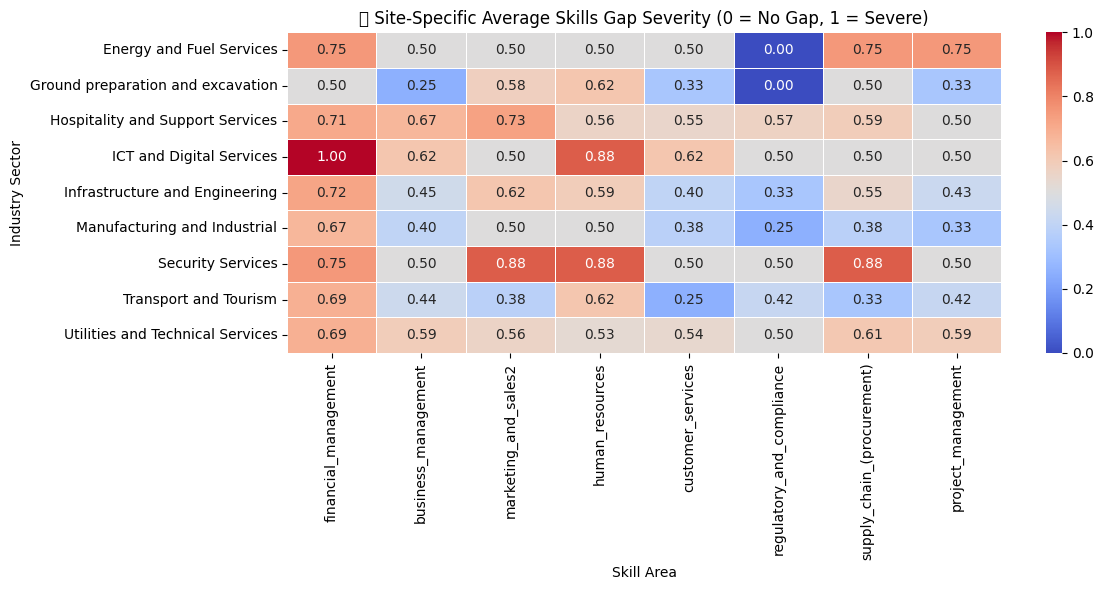

/tmp/ipython-input-11-1178138476.py:118: UserWarning: Glyph 129517 (\N{COMPASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129517 (\N{COMPASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


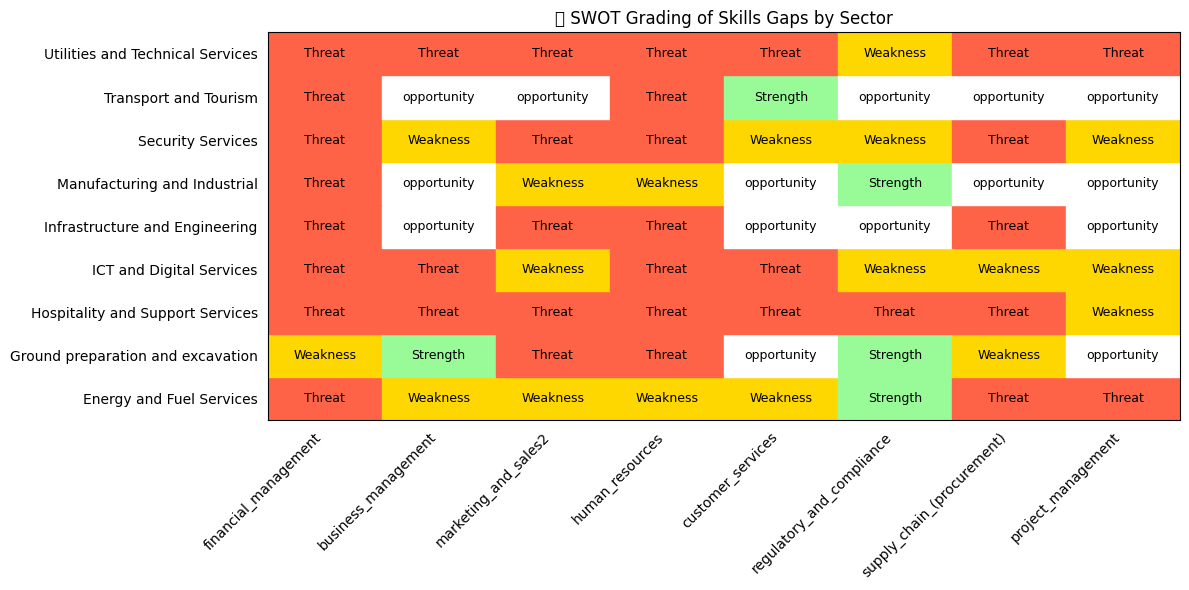

In [ ]:

# ---------------------------------------
# STEP 1: Normalize column names and load
# ---------------------------------------
df.columns = df.columns.str.strip().str.lower()

df = df.rename(columns={
    'industry_sector_of_the_business': 'industry',
    'location': 'site'
})

# -------------------------------
# STEP 2: Define column mappings
# -------------------------------
skills_cols = [
    'financial_management', 'business_management', 'marketing_and_sales2',
    'human_resources', 'customer_services', 'regulatory_and_compliance',
    'supply_chain_(procurement)', 'project_management'
]
available_cols = [col for col in skills_cols if col in df.columns]

# Weighted scoring for gap severity
gap_severity = {
    'serious gap': 1.0,
    'identified gap': 0.75,
    'moderate': 0.5,
    'negligible': 0.25,
    'no gap': 0.0
}

# -------------------------------
# STEP 3: Map severity values
# -------------------------------
skills_df = df[available_cols].applymap(lambda x: gap_severity.get(str(x).strip().lower(), np.nan))
skills_df['industry_sector_of_the_business'] = df['industry']

# -------------------------------
# STEP 4: Aggregate by industry
# -------------------------------
site_specific = skills_df.groupby('industry_sector_of_the_business')[available_cols].mean().round(2)

# -------------------------------
# STEP 5: SWOT Grading
# -------------------------------
def swot_grade(val):
    if val <= 0.25:
        return "Strength"
    elif val > 0.25 and val < 0.5:
      return "opportunity"
    elif val <= 0.5:
        return "Weakness"
    else:
        return "Threat"

swot_labels = site_specific.applymap(swot_grade)

# -------------------------------
# STEP 6: Plot 1 - Numeric Heatmap
# -------------------------------
plt.figure(figsize=(12, 6))
sns.heatmap(site_specific, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("📊 Site-Specific Average Skills Gap Severity (0 = No Gap, 1 = Severe)")
plt.xlabel("Skill Area")
plt.ylabel("Industry Sector")
plt.tight_layout()
plt.show()

# -------------------------------
# STEP 7: Plot 2 - SWOT Grading Heatmap
# -------------------------------
# Color mapping for SWOT categories
swot_cmap = {
    "Strength": "palegreen",
    "Weakness": "gold",
    "Threat": "tomato"
}

# Create a color matrix
color_matrix = swot_labels.copy()
for category, color in swot_cmap.items():
    color_matrix = color_matrix.replace(category, color)

# Create SWOT label heatmap manually
fig, ax = plt.subplots(figsize=(12, 6))

# Draw colored cells
for y in range(swot_labels.shape[0]):
    for x in range(swot_labels.shape[1]):
        label = swot_labels.iloc[y, x]
        color = swot_cmap.get(label, "white")
        ax.add_patch(plt.Rectangle((x, y), 1, 1, color=color))

# Overlay text labels
for y in range(swot_labels.shape[0]):
    for x in range(swot_labels.shape[1]):
        ax.text(x + 0.5, y + 0.5, swot_labels.iloc[y, x],
                ha='center', va='center', fontsize=9)

# Set ticks and labels
ax.set_xticks(np.arange(len(swot_labels.columns)) + 0.5)
ax.set_yticks(np.arange(len(swot_labels.index)) + 0.5)
ax.set_xticklabels(swot_labels.columns, rotation=45, ha="right")
ax.set_yticklabels(swot_labels.index)

# Final layout
ax.invert_yaxis()
ax.set_title("🧭 SWOT Grading of Skills Gaps by Sector")
ax.set_xlim(0, len(swot_labels.columns))
ax.set_ylim(0, len(swot_labels.index))
ax.set_xticks(np.arange(len(swot_labels.columns)) + 0.5, minor=True)
ax.set_yticks(np.arange(len(swot_labels.index)) + 0.5, minor=True)
ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.25)
ax.tick_params(which="major", bottom=False, left=False)
plt.tight_layout()
plt.show()


/tmp/ipython-input-12-2001279366.py:22: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  skills_df = df[available_cols].applymap(lambda x: gap_severity.get(str(x).strip().lower(), np.nan))
/tmp/ipython-input-12-2001279366.py:39: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  swot_labels = site_specific.applymap(swot_grade)
/tmp/ipython-input-12-2001279366.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=aggregate_gaps.values, y=aggregate_gaps.index, palette="viridis")


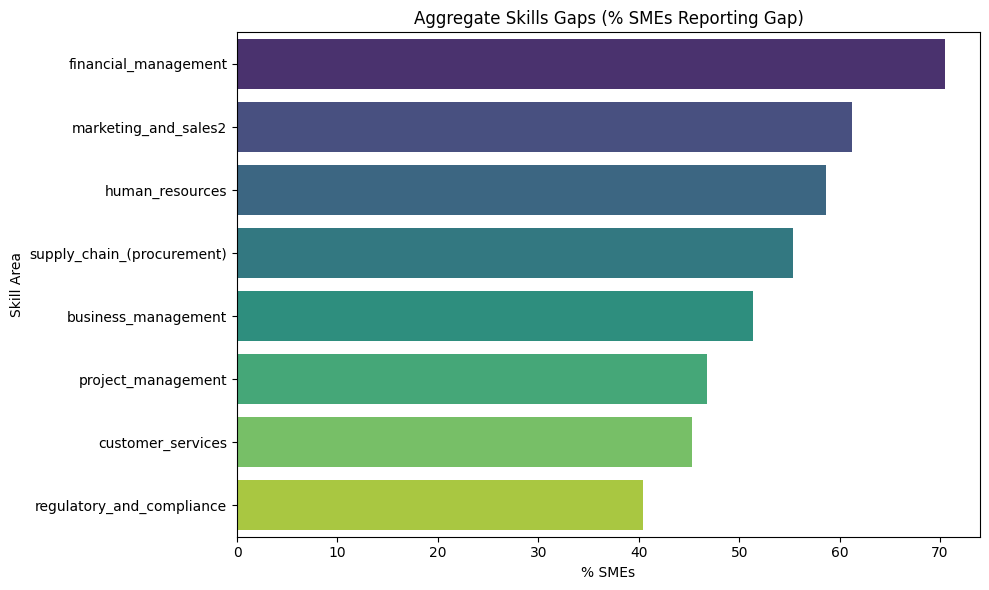

/tmp/ipython-input-12-2001279366.py:61: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


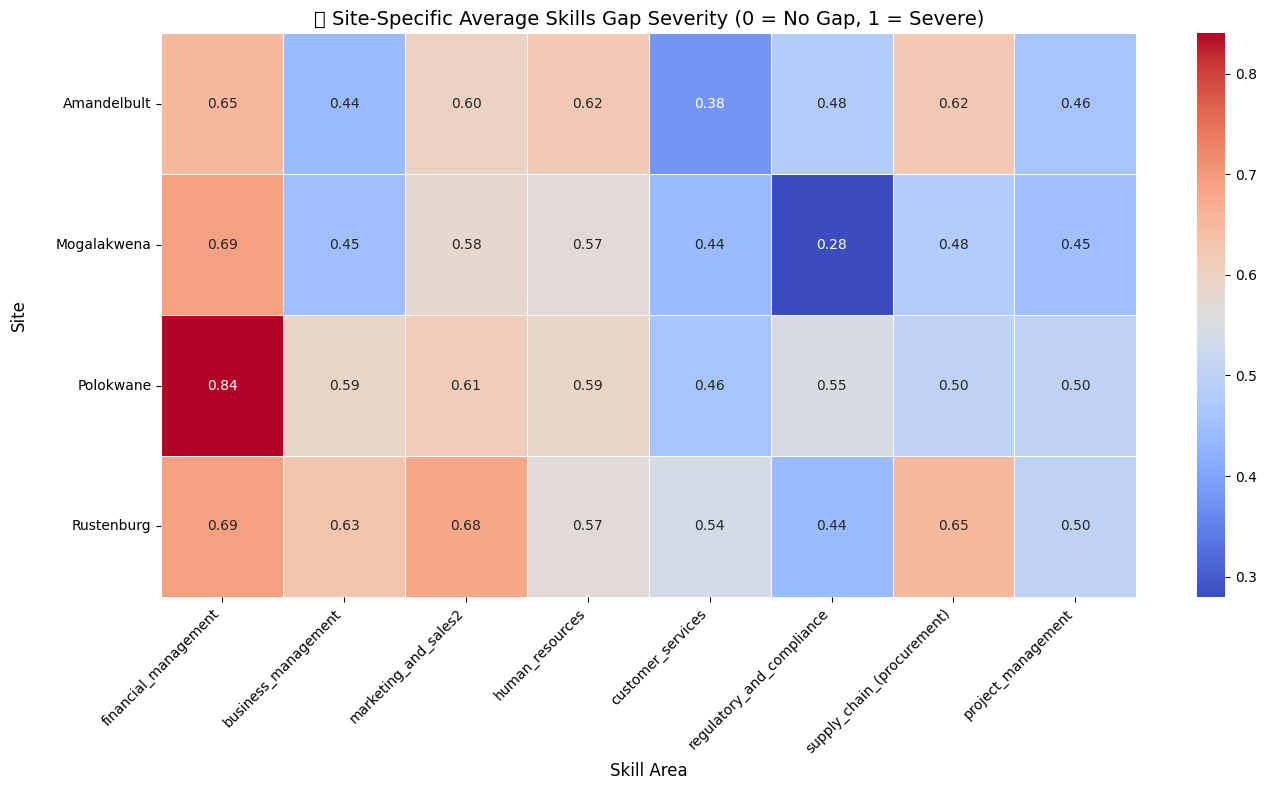

/tmp/ipython-input-12-2001279366.py:99: UserWarning: Glyph 129517 (\N{COMPASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129517 (\N{COMPASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


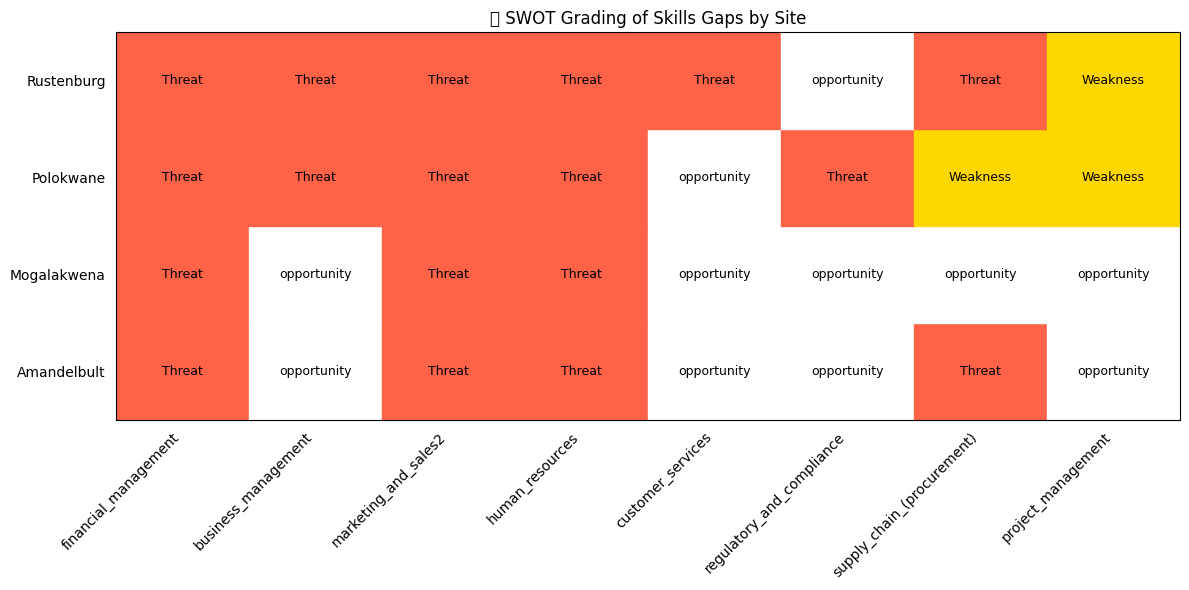

In [ ]:
# STEP 1: Normalize column names
df.columns = df.columns.str.strip().str.lower()

# STEP 2: Define relevant skills columns
skills_cols = [
    'financial_management', 'business_management', 'marketing_and_sales2',
    'human_resources', 'customer_services', 'regulatory_and_compliance',
    'supply_chain_(procurement)', 'project_management'
]
available_cols = [col for col in skills_cols if col in df.columns]

# STEP 3: Define gap severity weights
gap_severity = {
    'serious gap': 1.0,
    'identified gap': 0.75,
    'moderate': 0.5,
    'negligible': 0.25,
    'no gap': 0.0
}

# STEP 4: Apply scoring to all skill responses
skills_df = df[available_cols].applymap(lambda x: gap_severity.get(str(x).strip().lower(), np.nan))
skills_df['location'] = df['site']  # Adjust this column if needed

# STEP 5: Aggregate skill gap severity by site
site_specific = skills_df.groupby('location')[available_cols].mean().round(2)

# STEP 6: Create SWOT grading labels
def swot_grade(val):
    if val <= 0.25:
        return "Strength"
    elif val > 0.25 and val < 0.5:
        return "opportunity"
    elif val <= 0.5:
        return "Weakness"
    else:
        return "Threat"

swot_labels = site_specific.applymap(swot_grade)

# STEP 7: Plot 1 - Aggregate Skills Gaps (National Average)
aggregate_gaps = skills_df[available_cols].mean().sort_values(ascending=False) * 100
aggregate_gaps.name = "Aggregate Skills Gaps (% SMEs Reporting Gap)"

plt.figure(figsize=(10, 6))
sns.barplot(x=aggregate_gaps.values, y=aggregate_gaps.index, palette="viridis")
plt.title("Aggregate Skills Gaps (% SMEs Reporting Gap)")
plt.xlabel("% SMEs")
plt.ylabel("Skill Area")
plt.tight_layout()
plt.show()

# STEP 8: Plot 2 - Heatmap of Average Gap Scores by Site
plt.figure(figsize=(14, 8))
sns.heatmap(site_specific, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("📍 Site-Specific Average Skills Gap Severity (0 = No Gap, 1 = Severe)", fontsize=14)
plt.xlabel("Skill Area", fontsize=12)
plt.ylabel("Site", fontsize=12, labelpad=20)
plt.yticks(rotation=0, fontsize=10)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.tight_layout()
plt.show()

# STEP 9: Plot 3 - SWOT Grading Matrix (with Categories)
swot_cmap = {
    "Strength": "green",
    "Weakness": "gold",
    "Threat": "tomato"
}

fig, ax = plt.subplots(figsize=(12, 6))

# Draw color-coded grid
for y in range(swot_labels.shape[0]):
    for x in range(swot_labels.shape[1]):
        label = swot_labels.iloc[y, x]
        color = swot_cmap.get(label, "white")
        ax.add_patch(plt.Rectangle((x, y), 1, 1, color=color))

# Overlay text labels
for y in range(swot_labels.shape[0]):
    for x in range(swot_labels.shape[1]):
        ax.text(x + 0.5, y + 0.5, swot_labels.iloc[y, x],
                ha='center', va='center', fontsize=9)

# Axis configuration
ax.set_xticks(np.arange(len(swot_labels.columns)) + 0.5)
ax.set_yticks(np.arange(len(swot_labels.index)) + 0.5)
ax.set_xticklabels(swot_labels.columns, rotation=45, ha="right")
ax.set_yticklabels(swot_labels.index)
ax.invert_yaxis()
ax.set_title("🧭 SWOT Grading of Skills Gaps by Site")
ax.set_xlim(0, len(swot_labels.columns))
ax.set_ylim(0, len(swot_labels.index))
ax.set_xticks(np.arange(len(swot_labels.columns)) + 0.5, minor=True)
ax.set_yticks(np.arange(len(swot_labels.index)) + 0.5, minor=True)
ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.25)
ax.tick_params(which="major", bottom=False, left=False)
plt.tight_layout()
plt.show()
